In [1]:
import sys
import os

from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from dotenv import load_dotenv

from vap_sound.utils.evaluate_model import evaluate_model


load_dotenv()


# MODEL_PATH = os.environ.get("MODEL_PATH")
MODEL_PATH = "vap_model_6.pkl"
# LOG_MODEL_EVALUATION = os.environ.get("LOG_MODEL_EVALUATION")
LOG_MODEL_EVALUATION = "../logs/model_evaluation_6.log"

# LOG_MODEL_PREDICTION = os.environ.get("LOG_MODEL_PREDICTION")
LOG_MODEL_PREDICTION = "../logs/model_prediction_6.log"

In [2]:
import pickle

# Function to save model as pickle file
def save_model_pickle(model, path):
    with open(path, "wb") as f:
        pickle.dump(model, f)
    print("Model saved successfully as pickle file!")

# Function to load model from pickle file
def load_model_pickle(path):
    with open(path, "rb") as f:
        model = pickle.load(f)
    model.eval()
    print("Model loaded successfully from pickle file!")
    return model

# Collate function to pad variable-length sequences
def collate_fn(batch):
    features, labels = zip(*batch)
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    return features_padded, labels_padded

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn


####  DEFINE PARAMETERS ####

LSTM_HIDDEN_SIZE = 128
LSTM_LAYERS = 2

DROPOUT = 0.5


TRANSFORMER_HEAD_SIZE = 8
TRANSFORMER_NUM_LAYERS = 4
HIDDEN_DIM = 128


LEARNING_RATE = 0.001


NUM_EPOCHS = 20

class VAPModel(nn.Module):
    def __init__(self, 
                 input_dim=40, 
                lstm_hidden_dim=256,
                 num_heads=8,
                 transformer_layers=4, 
                 lstm_layers=2, 
                 output_dim=1):
        super(VAPModel, self).__init__()

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads),
            num_layers=transformer_layers
        )

        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, num_layers=3, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)

    def forward(self, x):
        x = self.transformer(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return torch.sigmoid(x)



# Collating data for training  --> Input is Pandas DataFrame
class VAPDataset(Dataset):
    def __init__(self, data_df, seq_length=100):
        # if isinstance(csv_files, str):
        #     csv_files = [csv_files]
        
        self.seq_length = seq_length
        # self.data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
        self.features = [torch.tensor(f) for f in data_df['features']]
        self.labels = [torch.tensor(l) for l in data_df['labels']]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        if feature.shape[0] > self.seq_length:
            feature = feature[-self.seq_length:]
            label = label[-self.seq_length:]
        else:
            pad_length = self.seq_length - feature.shape[0]
            feature = torch.cat([torch.zeros(pad_length, feature.shape[1]), feature], dim=0)
            label = torch.cat([torch.zeros(pad_length, label.shape[1]), label], dim=0)
        
        return feature, label
    

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

model1 = VAPModel()


# Training function
def train_model(training_data, batch_size=16, epochs=10, seq_length=100, learning_rate = LEARNING_RATE, model=model1):
    """
    Train the model using the provided training data.

    Args:
        model (nn.Module): The model to train.
        training_data (pd.DataFrame): DataFrame containing 'features' and 'labels' columns.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        seq_length (int): Fixed sequence length for padding/truncation.
    """
    if os.path.exists(MODEL_PATH):
        model = load_model_pickle(path=MODEL_PATH)
    # Create dataset and dataloader
    train_dataset = VAPDataset(training_data, seq_length=seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0

        # Training phase
        for features, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)  # Shape: (batch_size, seq_length, 1)

            # Ensure labels have the same shape as outputs
            if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
            elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                pass  # Do nothing
            else:
                raise ValueError(f"Unexpected labels shape: {labels.shape}")



            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase (using the same data for simplicity)
        model.eval()
        with torch.no_grad():
            for features, labels in train_loader:
                outputs = model(features)

                # Ensure labels have the same shape as outputs
                if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                    labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
                elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                    pass  # Do nothing
                else:
                    raise ValueError(f"Unexpected labels shape: {labels.shape}")

                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Log training and validation loss
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(train_loader):.4f}")
    save_model_pickle(model, path=MODEL_PATH)
    print("Training complete!")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

model1 = VAPModel()


# Training function
def train_model(training_data, batch_size=16, epochs=10, seq_length=100, learning_rate = LEARNING_RATE, model=model1):
    """
    Train the model using the provided training data.

    Args:
        model (nn.Module): The model to train.
        training_data (pd.DataFrame): DataFrame containing 'features' and 'labels' columns.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        seq_length (int): Fixed sequence length for padding/truncation.
    """
    if os.path.exists(MODEL_PATH):
        model = load_model_pickle(path=MODEL_PATH)
    # Create dataset and dataloader
    train_dataset = VAPDataset(training_data, seq_length=seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0

        # Training phase
        for features, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)  # Shape: (batch_size, seq_length, 1)

            # Ensure labels have the same shape as outputs
            if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
            elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                pass  # Do nothing
            else:
                raise ValueError(f"Unexpected labels shape: {labels.shape}")



            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase (using the same data for simplicity)
        model.eval()
        with torch.no_grad():
            for features, labels in train_loader:
                outputs = model(features)

                # Ensure labels have the same shape as outputs
                if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                    labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
                elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                    pass  # Do nothing
                else:
                    raise ValueError(f"Unexpected labels shape: {labels.shape}")

                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Log training and validation loss
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(train_loader):.4f}")
    save_model_pickle(model, path=MODEL_PATH)
    print("Training complete!")


In [5]:
from glob import glob
import os
import pandas as pd

data_dir = "/Users/shanujha/Desktop/voice_activity_prediction/voice_data_mozilla/en/clips"
audio_files = glob(os.path.join(data_dir, "*.mp3"))


CSV_FILE_PATH = "/Users/shanujha/Desktop/voice_activity_prediction/logs/trained_mp3_files.csv"


data = {"file_paths": audio_files, "processed": [0 for i in range(len(audio_files))]}
file_df = pd.DataFrame(data)
# print(file_df.head())
# csv_df.to_csv(CSV_FILE_PATH, index=False)

# file_df = pd.read_csv(CSV_FILE_PATH)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:1: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import VAD
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/trans

Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3673, Val Loss: 0.3536
Epoch 2/20, Train Loss: 0.3425, Val Loss: 0.3333
Epoch 3/20, Train Loss: 0.3333, Val Loss: 0.3348
Epoch 4/20, Train Loss: 0.3227, Val Loss: 0.3119
Epoch 5/20, Train Loss: 0.3205, Val Loss: 0.3131
Epoch 6/20, Train Loss: 0.3149, Val Loss: 0.3066
Epoch 7/20, Train Loss: 0.3095, Val Loss: 0.2971
Epoch 8/20, Train Loss: 0.2966, Val Loss: 0.3022
Epoch 9/20, Train Loss: 0.3211, Val Loss: 0.2911
Epoch 10/20, Train Loss: 0.3016, Val Loss: 0.2805
Epoch 11/20, Train Loss: 0.2927, Val Loss: 0.2813
Epoch 12/20, Train Loss: 0.2913, Val Loss: 0.2923
Epoch 13/20, Train Loss: 0.2904, Val Loss: 0.2760
Epoch 14/20, Train Loss: 0.2919, Val Loss: 0.2740
Epoch 15/20, Train Loss: 0.2792, Val Loss: 0.2769
Epoch 16/20, Train Loss: 0.2815, Val Loss: 0.2699
Epoch 17/20, Train Loss: 0.2743, Val Loss: 0.2588
Epoch 18/20, Train Loss: 0.2693, Val Loss: 0.2615
Epoch 19/20, Train Loss: 0.2769, Val Loss: 0.2511
Epoch 20/20, Tr

/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Test Accuracy: 0.5674
Confusion Matrix:
[[16522   203]
 [12775   500]]


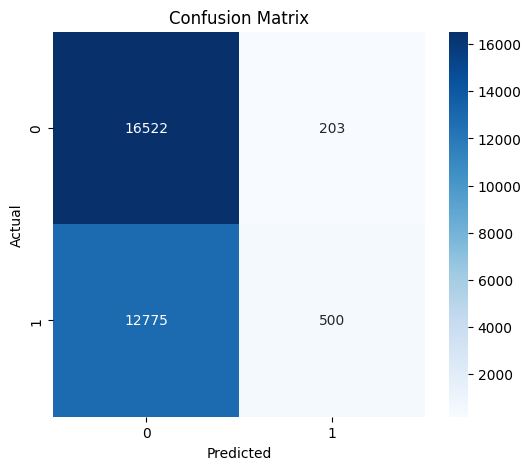

BATCH 1 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3785, Val Loss: 0.3324
Epoch 2/20, Train Loss: 0.3350, Val Loss: 0.3134
Epoch 3/20, Train Loss: 0.3220, Val Loss: 0.3067
Epoch 4/20, Train Loss: 0.3186, Val Loss: 0.3047
Epoch 5/20, Train Loss: 0.3149, Val Loss: 0.3019
Epoch 6/20, Train Loss: 0.3033, Val Loss: 0.3048
Epoch 7/20, Train Loss: 0.2954, Val Loss: 0.2918
Epoch 8/20, Train Loss: 0.2995, Val Loss: 0.3007
Epoch 9/20, Train Loss: 0.2872, Val Loss: 0.2905
Epoch 10/20, Train Loss: 0.2833, Val Loss: 0.2742
Epoch 11/20, Train Loss: 0.2889, Val Loss: 0.2712
Epoch 12/20, Train Loss: 0.2917, Val Loss: 0.2772
Epoch 13/20, Train Loss: 0.2824, Val Loss: 0.2642
Epoch 14/20, Train Loss: 0.2744, Val Loss: 0.2653
Epoch 15/20, Train Loss: 0.2703, Val Loss: 0.2625
Epoch 16/20, Train Loss: 0.2688, Val Loss: 0.2588
Epoch 17/20, Train Loss: 0.2628, Val Loss: 0.2953
Epoch 18/20, Train Loss: 0.2716, Val Loss: 0.2640
Epoch 19/20, Train Loss: 0.2595, Val Loss: 0.2432
Epoch 20/20, Tr

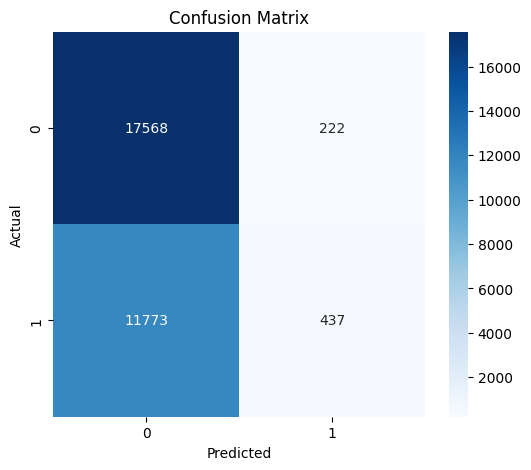

BATCH 2 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4366, Val Loss: 0.3878
Epoch 2/20, Train Loss: 0.3843, Val Loss: 0.3638
Epoch 3/20, Train Loss: 0.3697, Val Loss: 0.3557
Epoch 4/20, Train Loss: 0.3576, Val Loss: 0.3418
Epoch 5/20, Train Loss: 0.3450, Val Loss: 0.3352
Epoch 6/20, Train Loss: 0.3426, Val Loss: 0.3206
Epoch 7/20, Train Loss: 0.3421, Val Loss: 0.3361
Epoch 8/20, Train Loss: 0.3410, Val Loss: 0.3213
Epoch 9/20, Train Loss: 0.3261, Val Loss: 0.3194
Epoch 10/20, Train Loss: 0.3330, Val Loss: 0.3270
Epoch 11/20, Train Loss: 0.3325, Val Loss: 0.3254
Epoch 12/20, Train Loss: 0.3287, Val Loss: 0.3071
Epoch 13/20, Train Loss: 0.3169, Val Loss: 0.3046
Epoch 14/20, Train Loss: 0.3116, Val Loss: 0.2943
Epoch 15/20, Train Loss: 0.3004, Val Loss: 0.3139
Epoch 16/20, Train Loss: 0.3146, Val Loss: 0.2946
Epoch 17/20, Train Loss: 0.3070, Val Loss: 0.2911
Epoch 18/20, Train Loss: 0.2969, Val Loss: 0.2831
Epoch 19/20, Train Loss: 0.2992, Val Loss: 0.2803
Epoch 20/20, Tr

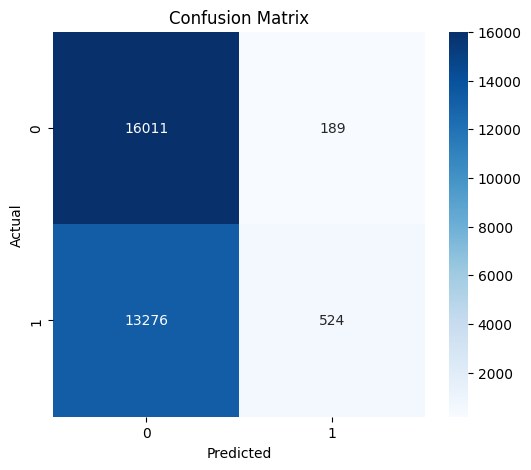

BATCH 3 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4099, Val Loss: 0.3633
Epoch 2/20, Train Loss: 0.3565, Val Loss: 0.3474
Epoch 3/20, Train Loss: 0.3429, Val Loss: 0.3212
Epoch 4/20, Train Loss: 0.3321, Val Loss: 0.3253
Epoch 5/20, Train Loss: 0.3320, Val Loss: 0.3292
Epoch 6/20, Train Loss: 0.3268, Val Loss: 0.3181
Epoch 7/20, Train Loss: 0.3117, Val Loss: 0.2958
Epoch 8/20, Train Loss: 0.3069, Val Loss: 0.2925
Epoch 9/20, Train Loss: 0.3032, Val Loss: 0.2917
Epoch 10/20, Train Loss: 0.3050, Val Loss: 0.3044
Epoch 11/20, Train Loss: 0.2872, Val Loss: 0.2781
Epoch 12/20, Train Loss: 0.3037, Val Loss: 0.2947
Epoch 13/20, Train Loss: 0.3184, Val Loss: 0.3006
Epoch 14/20, Train Loss: 0.3063, Val Loss: 0.2876
Epoch 15/20, Train Loss: 0.2915, Val Loss: 0.2849
Epoch 16/20, Train Loss: 0.2817, Val Loss: 0.2861
Epoch 17/20, Train Loss: 0.3531, Val Loss: 0.3660
Epoch 18/20, Train Loss: 0.3687, Val Loss: 0.3305
Epoch 19/20, Train Loss: 0.3265, Val Loss: 0.3166
Epoch 20/20, Tr

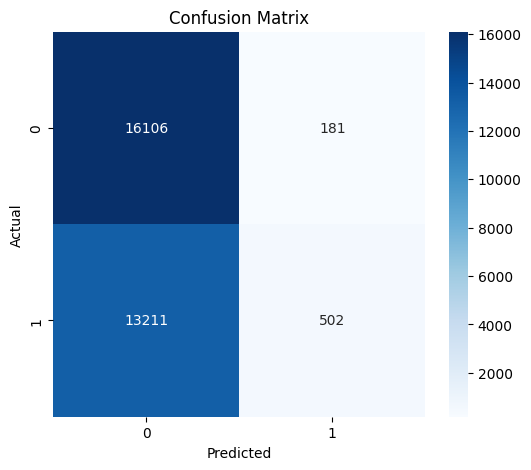

BATCH 4 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4010, Val Loss: 0.3723
Epoch 2/20, Train Loss: 0.3734, Val Loss: 0.3737
Epoch 3/20, Train Loss: 0.3627, Val Loss: 0.3480
Epoch 4/20, Train Loss: 0.3553, Val Loss: 0.3346
Epoch 5/20, Train Loss: 0.3386, Val Loss: 0.3342
Epoch 6/20, Train Loss: 0.3330, Val Loss: 0.3209
Epoch 7/20, Train Loss: 0.3221, Val Loss: 0.3082
Epoch 8/20, Train Loss: 0.3168, Val Loss: 0.3068
Epoch 9/20, Train Loss: 0.3062, Val Loss: 0.3151
Epoch 10/20, Train Loss: 0.3021, Val Loss: 0.2876
Epoch 11/20, Train Loss: 0.3001, Val Loss: 0.2962
Epoch 12/20, Train Loss: 0.2946, Val Loss: 0.2963
Epoch 13/20, Train Loss: 0.3060, Val Loss: 0.2876
Epoch 14/20, Train Loss: 0.3003, Val Loss: 0.2789
Epoch 15/20, Train Loss: 0.2796, Val Loss: 0.2753
Epoch 16/20, Train Loss: 0.2912, Val Loss: 0.2708
Epoch 17/20, Train Loss: 0.2818, Val Loss: 0.2835
Epoch 18/20, Train Loss: 0.2835, Val Loss: 0.2628
Epoch 19/20, Train Loss: 0.2799, Val Loss: 0.2701
Epoch 20/20, Tr

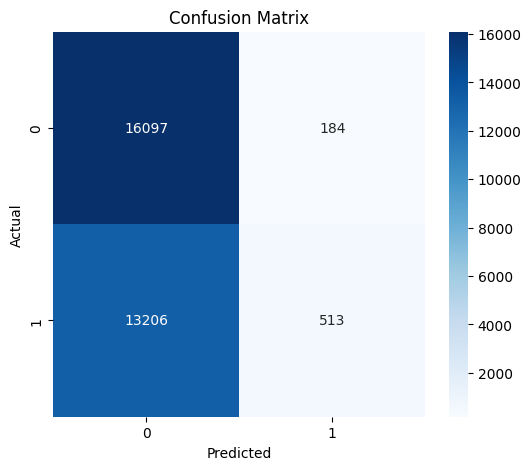

BATCH 5 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3929, Val Loss: 0.3702
Epoch 2/20, Train Loss: 0.3661, Val Loss: 0.3449
Epoch 3/20, Train Loss: 0.3453, Val Loss: 0.3336
Epoch 4/20, Train Loss: 0.3318, Val Loss: 0.3233
Epoch 5/20, Train Loss: 0.3278, Val Loss: 0.3166
Epoch 6/20, Train Loss: 0.3295, Val Loss: 0.3166
Epoch 7/20, Train Loss: 0.3128, Val Loss: 0.3086
Epoch 8/20, Train Loss: 0.3036, Val Loss: 0.3068
Epoch 9/20, Train Loss: 0.3045, Val Loss: 0.2975
Epoch 10/20, Train Loss: 0.3053, Val Loss: 0.2903
Epoch 11/20, Train Loss: 0.2992, Val Loss: 0.2890
Epoch 12/20, Train Loss: 0.2962, Val Loss: 0.2913
Epoch 13/20, Train Loss: 0.2985, Val Loss: 0.2899
Epoch 14/20, Train Loss: 0.2907, Val Loss: 0.2712
Epoch 15/20, Train Loss: 0.2876, Val Loss: 0.2782
Epoch 16/20, Train Loss: 0.2945, Val Loss: 0.2706
Epoch 17/20, Train Loss: 0.2727, Val Loss: 0.2639
Epoch 18/20, Train Loss: 0.2677, Val Loss: 0.2596
Epoch 19/20, Train Loss: 0.2624, Val Loss: 0.2646
Epoch 20/20, Tr

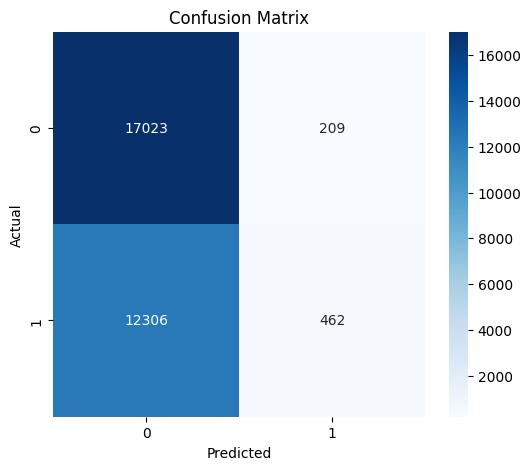

BATCH 6 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4052, Val Loss: 0.3721
Epoch 2/20, Train Loss: 0.3615, Val Loss: 0.3449
Epoch 3/20, Train Loss: 0.3403, Val Loss: 0.3318
Epoch 4/20, Train Loss: 0.3305, Val Loss: 0.3110
Epoch 5/20, Train Loss: 0.3239, Val Loss: 0.3145
Epoch 6/20, Train Loss: 0.3183, Val Loss: 0.2995
Epoch 7/20, Train Loss: 0.3117, Val Loss: 0.3051
Epoch 8/20, Train Loss: 0.3104, Val Loss: 0.2867
Epoch 9/20, Train Loss: 0.2963, Val Loss: 0.2785
Epoch 10/20, Train Loss: 0.2924, Val Loss: 0.2799
Epoch 11/20, Train Loss: 0.2769, Val Loss: 0.2732
Epoch 12/20, Train Loss: 0.2815, Val Loss: 0.2704
Epoch 13/20, Train Loss: 0.2790, Val Loss: 0.2568
Epoch 14/20, Train Loss: 0.2592, Val Loss: 0.2546
Epoch 15/20, Train Loss: 0.2597, Val Loss: 0.2556
Epoch 16/20, Train Loss: 0.2517, Val Loss: 0.2470
Epoch 17/20, Train Loss: 0.2471, Val Loss: 0.2665
Epoch 18/20, Train Loss: 0.2516, Val Loss: 0.2561
Epoch 19/20, Train Loss: 0.2503, Val Loss: 0.2377
Epoch 20/20, Tr

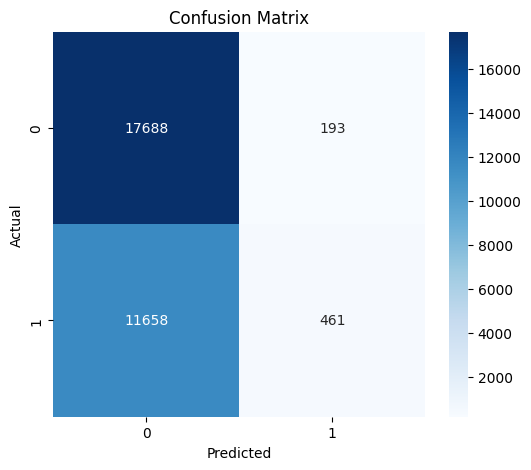

BATCH 7 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4048, Val Loss: 0.3592
Epoch 2/20, Train Loss: 0.3511, Val Loss: 0.3422
Epoch 3/20, Train Loss: 0.3347, Val Loss: 0.3222
Epoch 4/20, Train Loss: 0.3232, Val Loss: 0.3086
Epoch 5/20, Train Loss: 0.3082, Val Loss: 0.3005
Epoch 6/20, Train Loss: 0.3165, Val Loss: 0.2965
Epoch 7/20, Train Loss: 0.2946, Val Loss: 0.2867
Epoch 8/20, Train Loss: 0.2836, Val Loss: 0.2831
Epoch 9/20, Train Loss: 0.2762, Val Loss: 0.2606
Epoch 10/20, Train Loss: 0.2737, Val Loss: 0.2647
Epoch 11/20, Train Loss: 0.2739, Val Loss: 0.2591
Epoch 12/20, Train Loss: 0.2694, Val Loss: 0.2643
Epoch 13/20, Train Loss: 0.2498, Val Loss: 0.2405
Epoch 14/20, Train Loss: 0.2469, Val Loss: 0.2517
Epoch 15/20, Train Loss: 0.2671, Val Loss: 0.2482
Epoch 16/20, Train Loss: 0.2656, Val Loss: 0.2460
Epoch 17/20, Train Loss: 0.2527, Val Loss: 0.2284
Epoch 18/20, Train Loss: 0.2273, Val Loss: 0.2162
Epoch 19/20, Train Loss: 0.2269, Val Loss: 0.2056
Epoch 20/20, Tr

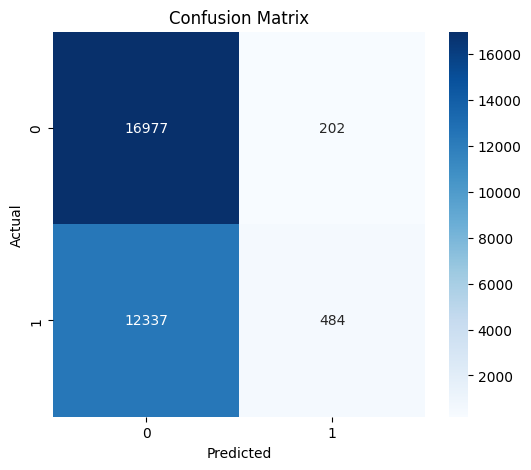

BATCH 8 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4166, Val Loss: 0.3464
Epoch 2/20, Train Loss: 0.3454, Val Loss: 0.3466
Epoch 3/20, Train Loss: 0.3275, Val Loss: 0.3123
Epoch 4/20, Train Loss: 0.3179, Val Loss: 0.3099
Epoch 5/20, Train Loss: 0.3205, Val Loss: 0.2907
Epoch 6/20, Train Loss: 0.3075, Val Loss: 0.2920
Epoch 7/20, Train Loss: 0.2928, Val Loss: 0.2830
Epoch 8/20, Train Loss: 0.2796, Val Loss: 0.2676
Epoch 9/20, Train Loss: 0.2770, Val Loss: 0.2804
Epoch 10/20, Train Loss: 0.2772, Val Loss: 0.2660
Epoch 11/20, Train Loss: 0.2650, Val Loss: 0.2604
Epoch 12/20, Train Loss: 0.2606, Val Loss: 0.2579
Epoch 13/20, Train Loss: 0.2611, Val Loss: 0.2494
Epoch 14/20, Train Loss: 0.2598, Val Loss: 0.2447
Epoch 15/20, Train Loss: 0.2577, Val Loss: 0.2547
Epoch 16/20, Train Loss: 0.3128, Val Loss: 0.2697
Epoch 17/20, Train Loss: 0.2927, Val Loss: 0.2643
Epoch 18/20, Train Loss: 0.2648, Val Loss: 0.2521
Epoch 19/20, Train Loss: 0.2469, Val Loss: 0.2401
Epoch 20/20, Tr

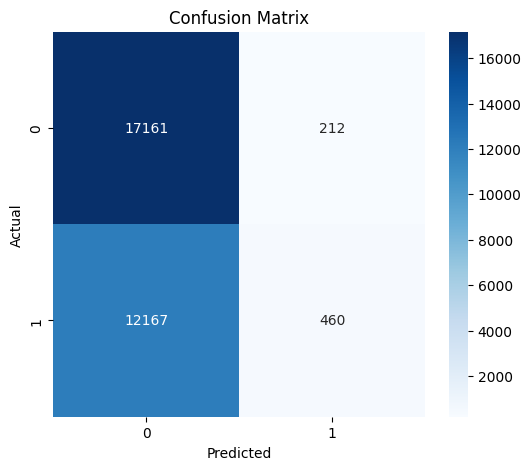

BATCH 9 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3916, Val Loss: 0.3459
Epoch 2/20, Train Loss: 0.3377, Val Loss: 0.3253
Epoch 3/20, Train Loss: 0.3261, Val Loss: 0.3105
Epoch 4/20, Train Loss: 0.3116, Val Loss: 0.2994
Epoch 5/20, Train Loss: 0.2997, Val Loss: 0.2885
Epoch 6/20, Train Loss: 0.3073, Val Loss: 0.3229
Epoch 7/20, Train Loss: 0.3112, Val Loss: 0.2805
Epoch 8/20, Train Loss: 0.2863, Val Loss: 0.2772
Epoch 9/20, Train Loss: 0.2706, Val Loss: 0.2607
Epoch 10/20, Train Loss: 0.2707, Val Loss: 0.2935
Epoch 11/20, Train Loss: 0.2968, Val Loss: 0.2719
Epoch 12/20, Train Loss: 0.2744, Val Loss: 0.2672
Epoch 13/20, Train Loss: 0.2890, Val Loss: 0.2747
Epoch 14/20, Train Loss: 0.2733, Val Loss: 0.2634
Epoch 15/20, Train Loss: 0.2500, Val Loss: 0.2447
Epoch 16/20, Train Loss: 0.2512, Val Loss: 0.2281
Epoch 17/20, Train Loss: 0.2448, Val Loss: 0.2243
Epoch 18/20, Train Loss: 0.2285, Val Loss: 0.2204
Epoch 19/20, Train Loss: 0.2294, Val Loss: 0.2183
Epoch 20/20, Tr

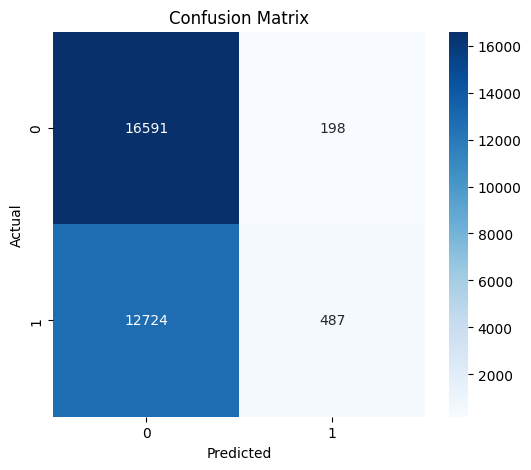

BATCH 10 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4250, Val Loss: 0.3679
Epoch 2/20, Train Loss: 0.3741, Val Loss: 0.3474
Epoch 3/20, Train Loss: 0.3517, Val Loss: 0.3303
Epoch 4/20, Train Loss: 0.3277, Val Loss: 0.3172
Epoch 5/20, Train Loss: 0.3194, Val Loss: 0.3056
Epoch 6/20, Train Loss: 0.3125, Val Loss: 0.3136
Epoch 7/20, Train Loss: 0.3041, Val Loss: 0.3027
Epoch 8/20, Train Loss: 0.3002, Val Loss: 0.2830
Epoch 9/20, Train Loss: 0.2890, Val Loss: 0.2947
Epoch 10/20, Train Loss: 0.2820, Val Loss: 0.2882
Epoch 11/20, Train Loss: 0.2828, Val Loss: 0.2590
Epoch 12/20, Train Loss: 0.2909, Val Loss: 0.2822
Epoch 13/20, Train Loss: 0.2849, Val Loss: 0.2636
Epoch 14/20, Train Loss: 0.2750, Val Loss: 0.2619
Epoch 15/20, Train Loss: 0.2639, Val Loss: 0.2780
Epoch 16/20, Train Loss: 0.2642, Val Loss: 0.2522
Epoch 17/20, Train Loss: 0.2510, Val Loss: 0.2348
Epoch 18/20, Train Loss: 0.2402, Val Loss: 0.2294
Epoch 19/20, Train Loss: 0.2285, Val Loss: 0.2229
Epoch 20/20, Tr

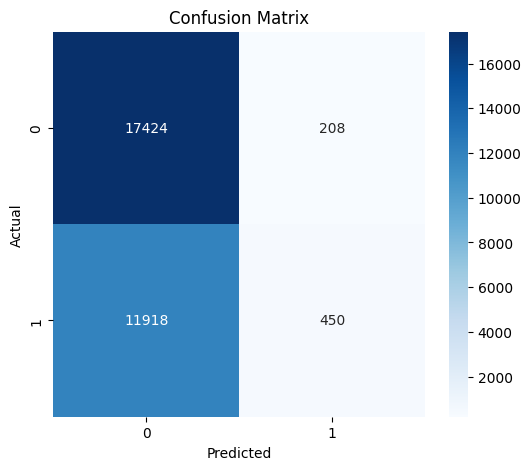

BATCH 11 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4539, Val Loss: 0.3826
Epoch 2/20, Train Loss: 0.3765, Val Loss: 0.3601
Epoch 3/20, Train Loss: 0.3487, Val Loss: 0.3347
Epoch 4/20, Train Loss: 0.3437, Val Loss: 0.3278
Epoch 5/20, Train Loss: 0.3216, Val Loss: 0.3100
Epoch 6/20, Train Loss: 0.3248, Val Loss: 0.3040
Epoch 7/20, Train Loss: 0.3074, Val Loss: 0.2979
Epoch 8/20, Train Loss: 0.3118, Val Loss: 0.2994
Epoch 9/20, Train Loss: 0.3013, Val Loss: 0.2862
Epoch 10/20, Train Loss: 0.2902, Val Loss: 0.2692
Epoch 11/20, Train Loss: 0.2999, Val Loss: 0.2861
Epoch 12/20, Train Loss: 0.2912, Val Loss: 0.2692
Epoch 13/20, Train Loss: 0.2784, Val Loss: 0.2683
Epoch 14/20, Train Loss: 0.2793, Val Loss: 0.2795
Epoch 15/20, Train Loss: 0.2742, Val Loss: 0.2672
Epoch 16/20, Train Loss: 0.2649, Val Loss: 0.2668
Epoch 17/20, Train Loss: 0.2647, Val Loss: 0.2469
Epoch 18/20, Train Loss: 0.2520, Val Loss: 0.2462
Epoch 19/20, Train Loss: 0.2631, Val Loss: 0.2370
Epoch 20/20, Tr

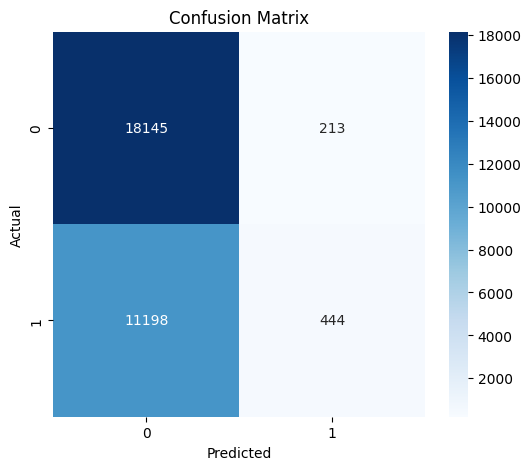

BATCH 12 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3958, Val Loss: 0.3452
Epoch 2/20, Train Loss: 0.3476, Val Loss: 0.3109
Epoch 3/20, Train Loss: 0.3236, Val Loss: 0.3152
Epoch 4/20, Train Loss: 0.2977, Val Loss: 0.2857
Epoch 5/20, Train Loss: 0.2870, Val Loss: 0.2782
Epoch 6/20, Train Loss: 0.2793, Val Loss: 0.2650
Epoch 7/20, Train Loss: 0.2663, Val Loss: 0.2722
Epoch 8/20, Train Loss: 0.2599, Val Loss: 0.2535
Epoch 9/20, Train Loss: 0.2600, Val Loss: 0.2435
Epoch 10/20, Train Loss: 0.2450, Val Loss: 0.2250
Epoch 11/20, Train Loss: 0.2834, Val Loss: 0.2830
Epoch 12/20, Train Loss: 0.2547, Val Loss: 0.2698
Epoch 13/20, Train Loss: 0.2805, Val Loss: 0.2505
Epoch 14/20, Train Loss: 0.2501, Val Loss: 0.2249
Epoch 15/20, Train Loss: 0.2238, Val Loss: 0.2158
Epoch 16/20, Train Loss: 0.2209, Val Loss: 0.2302
Epoch 17/20, Train Loss: 0.2189, Val Loss: 0.2061
Epoch 18/20, Train Loss: 0.2087, Val Loss: 0.1870
Epoch 19/20, Train Loss: 0.2009, Val Loss: 0.1889
Epoch 20/20, Tr

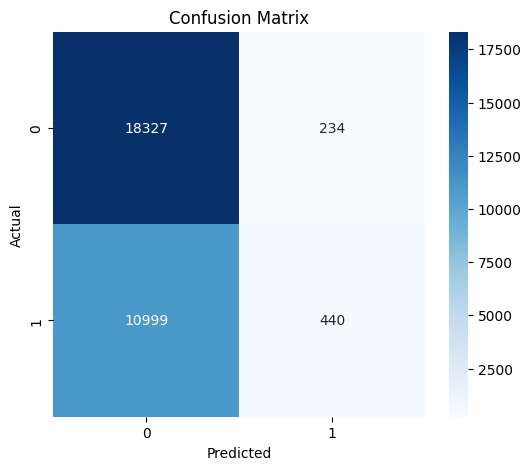

BATCH 13 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4124, Val Loss: 0.3627
Epoch 2/20, Train Loss: 0.3708, Val Loss: 0.3237
Epoch 3/20, Train Loss: 0.3258, Val Loss: 0.3073
Epoch 4/20, Train Loss: 0.3076, Val Loss: 0.2983
Epoch 5/20, Train Loss: 0.2968, Val Loss: 0.2863
Epoch 6/20, Train Loss: 0.2850, Val Loss: 0.2799
Epoch 7/20, Train Loss: 0.2793, Val Loss: 0.2707
Epoch 8/20, Train Loss: 0.2685, Val Loss: 0.2642
Epoch 9/20, Train Loss: 0.2684, Val Loss: 0.2443
Epoch 10/20, Train Loss: 0.2638, Val Loss: 0.2408
Epoch 11/20, Train Loss: 0.2585, Val Loss: 0.2515
Epoch 12/20, Train Loss: 0.2525, Val Loss: 0.2469
Epoch 13/20, Train Loss: 0.2481, Val Loss: 0.2566
Epoch 14/20, Train Loss: 0.2579, Val Loss: 0.2441
Epoch 15/20, Train Loss: 0.2677, Val Loss: 0.2437
Epoch 16/20, Train Loss: 0.2430, Val Loss: 0.2315
Epoch 17/20, Train Loss: 0.2418, Val Loss: 0.2347
Epoch 18/20, Train Loss: 0.2329, Val Loss: 0.2215
Epoch 19/20, Train Loss: 0.2227, Val Loss: 0.2073
Epoch 20/20, Tr

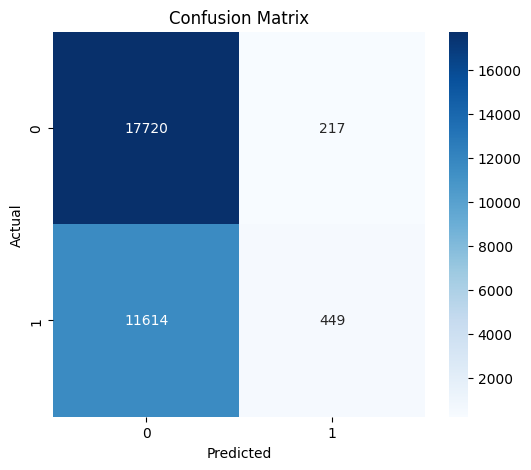

BATCH 14 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4188, Val Loss: 0.3530
Epoch 2/20, Train Loss: 0.3539, Val Loss: 0.3264
Epoch 3/20, Train Loss: 0.3256, Val Loss: 0.3165
Epoch 4/20, Train Loss: 0.3167, Val Loss: 0.2931
Epoch 5/20, Train Loss: 0.2964, Val Loss: 0.2898
Epoch 6/20, Train Loss: 0.2888, Val Loss: 0.2668
Epoch 7/20, Train Loss: 0.2775, Val Loss: 0.2680
Epoch 8/20, Train Loss: 0.2833, Val Loss: 0.2844
Epoch 9/20, Train Loss: 0.2717, Val Loss: 0.2478
Epoch 10/20, Train Loss: 0.2635, Val Loss: 0.2562
Epoch 11/20, Train Loss: 0.2504, Val Loss: 0.2464
Epoch 12/20, Train Loss: 0.2820, Val Loss: 0.2556
Epoch 13/20, Train Loss: 0.2751, Val Loss: 0.2655
Epoch 14/20, Train Loss: 0.2719, Val Loss: 0.2565
Epoch 15/20, Train Loss: 0.2616, Val Loss: 0.2471
Epoch 16/20, Train Loss: 0.2469, Val Loss: 0.2403
Epoch 17/20, Train Loss: 0.2396, Val Loss: 0.2354
Epoch 18/20, Train Loss: 0.2258, Val Loss: 0.2149
Epoch 19/20, Train Loss: 0.2341, Val Loss: 0.2155
Epoch 20/20, Tr

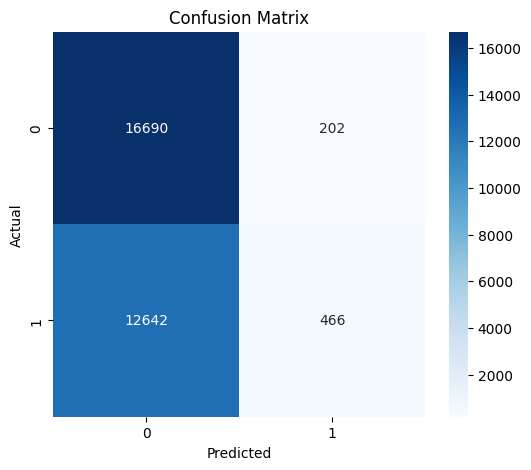

BATCH 15 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4141, Val Loss: 0.3460
Epoch 2/20, Train Loss: 0.3444, Val Loss: 0.3132
Epoch 3/20, Train Loss: 0.3168, Val Loss: 0.2956
Epoch 4/20, Train Loss: 0.2977, Val Loss: 0.2781
Epoch 5/20, Train Loss: 0.2879, Val Loss: 0.2718
Epoch 6/20, Train Loss: 0.2788, Val Loss: 0.2723
Epoch 7/20, Train Loss: 0.2855, Val Loss: 0.2576
Epoch 8/20, Train Loss: 0.2643, Val Loss: 0.2537
Epoch 9/20, Train Loss: 0.2543, Val Loss: 0.2439
Epoch 10/20, Train Loss: 0.2490, Val Loss: 0.2326
Epoch 11/20, Train Loss: 0.2534, Val Loss: 0.2533
Epoch 12/20, Train Loss: 0.2449, Val Loss: 0.2221
Epoch 13/20, Train Loss: 0.2275, Val Loss: 0.2144
Epoch 14/20, Train Loss: 0.2385, Val Loss: 0.2328
Epoch 15/20, Train Loss: 0.2434, Val Loss: 0.2335
Epoch 16/20, Train Loss: 0.2441, Val Loss: 0.2315
Epoch 17/20, Train Loss: 0.2231, Val Loss: 0.2147
Epoch 18/20, Train Loss: 0.2360, Val Loss: 0.2278
Epoch 19/20, Train Loss: 0.2209, Val Loss: 0.2211
Epoch 20/20, Tr

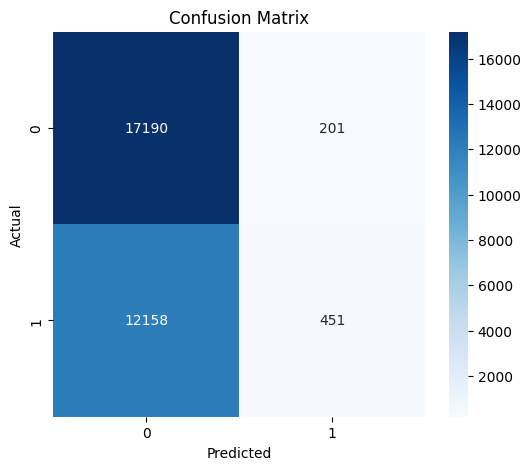

BATCH 16 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4221, Val Loss: 0.3661
Epoch 2/20, Train Loss: 0.3602, Val Loss: 0.3531
Epoch 3/20, Train Loss: 0.3433, Val Loss: 0.3383
Epoch 4/20, Train Loss: 0.3319, Val Loss: 0.3089
Epoch 5/20, Train Loss: 0.3141, Val Loss: 0.3051
Epoch 6/20, Train Loss: 0.3137, Val Loss: 0.2933
Epoch 7/20, Train Loss: 0.2905, Val Loss: 0.2761
Epoch 8/20, Train Loss: 0.2734, Val Loss: 0.2604
Epoch 9/20, Train Loss: 0.2881, Val Loss: 0.2721
Epoch 10/20, Train Loss: 0.2791, Val Loss: 0.2710
Epoch 11/20, Train Loss: 0.2813, Val Loss: 0.2611
Epoch 12/20, Train Loss: 0.2609, Val Loss: 0.2404
Epoch 13/20, Train Loss: 0.2454, Val Loss: 0.2302
Epoch 14/20, Train Loss: 0.2324, Val Loss: 0.2190
Epoch 15/20, Train Loss: 0.2328, Val Loss: 0.2282
Epoch 16/20, Train Loss: 0.2194, Val Loss: 0.2227
Epoch 17/20, Train Loss: 0.2221, Val Loss: 0.2067
Epoch 18/20, Train Loss: 0.2251, Val Loss: 0.2204
Epoch 19/20, Train Loss: 0.2612, Val Loss: 0.2514
Epoch 20/20, Tr

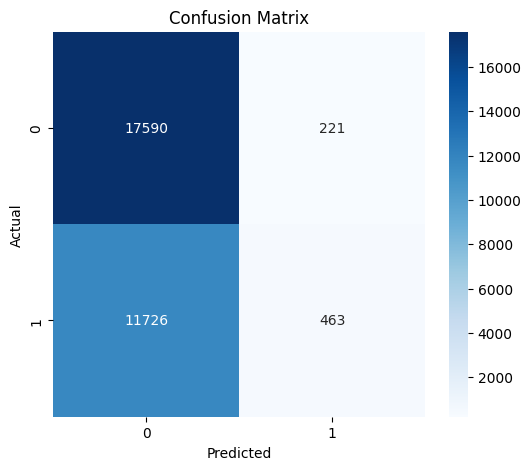

BATCH 17 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3947, Val Loss: 0.3294
Epoch 2/20, Train Loss: 0.3304, Val Loss: 0.3147
Epoch 3/20, Train Loss: 0.3125, Val Loss: 0.2932
Epoch 4/20, Train Loss: 0.2961, Val Loss: 0.2806
Epoch 5/20, Train Loss: 0.2830, Val Loss: 0.2707
Epoch 6/20, Train Loss: 0.2762, Val Loss: 0.2669
Epoch 7/20, Train Loss: 0.2659, Val Loss: 0.2459
Epoch 8/20, Train Loss: 0.2555, Val Loss: 0.2436
Epoch 9/20, Train Loss: 0.2469, Val Loss: 0.2545
Epoch 10/20, Train Loss: 0.2448, Val Loss: 0.2586
Epoch 11/20, Train Loss: 0.2442, Val Loss: 0.2261
Epoch 12/20, Train Loss: 0.2388, Val Loss: 0.2291
Epoch 13/20, Train Loss: 0.2320, Val Loss: 0.2130
Epoch 14/20, Train Loss: 0.2548, Val Loss: 0.2706
Epoch 15/20, Train Loss: 0.2503, Val Loss: 0.2386
Epoch 16/20, Train Loss: 0.2224, Val Loss: 0.2162
Epoch 17/20, Train Loss: 0.2099, Val Loss: 0.2054
Epoch 18/20, Train Loss: 0.2119, Val Loss: 0.1991
Epoch 19/20, Train Loss: 0.2112, Val Loss: 0.1953
Epoch 20/20, Tr

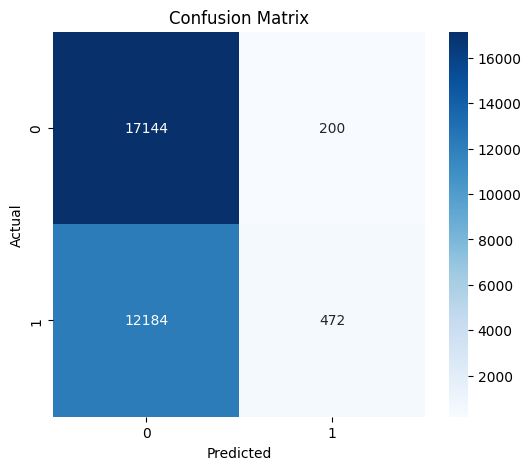

BATCH 18 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3877, Val Loss: 0.3375
Epoch 2/20, Train Loss: 0.3254, Val Loss: 0.2983
Epoch 3/20, Train Loss: 0.2984, Val Loss: 0.2857
Epoch 4/20, Train Loss: 0.2762, Val Loss: 0.2796
Epoch 5/20, Train Loss: 0.2739, Val Loss: 0.2558
Epoch 6/20, Train Loss: 0.2551, Val Loss: 0.2511
Epoch 7/20, Train Loss: 0.2692, Val Loss: 0.2532
Epoch 8/20, Train Loss: 0.2635, Val Loss: 0.2646
Epoch 9/20, Train Loss: 0.2561, Val Loss: 0.2227
Epoch 10/20, Train Loss: 0.2340, Val Loss: 0.2440
Epoch 11/20, Train Loss: 0.2216, Val Loss: 0.2313
Epoch 12/20, Train Loss: 0.2193, Val Loss: 0.1999
Epoch 13/20, Train Loss: 0.2271, Val Loss: 0.2092
Epoch 14/20, Train Loss: 0.2153, Val Loss: 0.2177
Epoch 15/20, Train Loss: 0.2176, Val Loss: 0.2170
Epoch 16/20, Train Loss: 0.2058, Val Loss: 0.2055
Epoch 17/20, Train Loss: 0.2111, Val Loss: 0.1953
Epoch 18/20, Train Loss: 0.2012, Val Loss: 0.2079
Epoch 19/20, Train Loss: 0.1959, Val Loss: 0.1937
Epoch 20/20, Tr

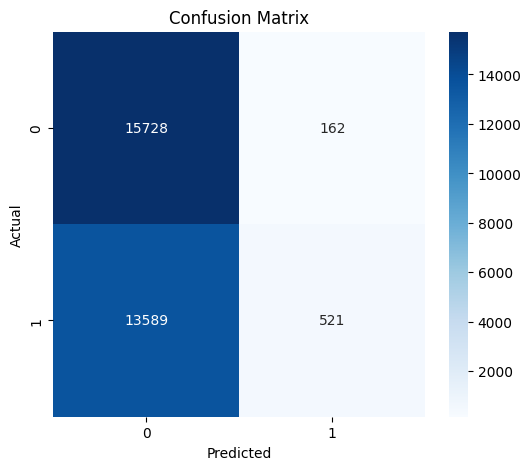

BATCH 19 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3880, Val Loss: 0.3375
Epoch 2/20, Train Loss: 0.3307, Val Loss: 0.3232
Epoch 3/20, Train Loss: 0.3203, Val Loss: 0.3007
Epoch 4/20, Train Loss: 0.3156, Val Loss: 0.2905
Epoch 5/20, Train Loss: 0.2929, Val Loss: 0.2831
Epoch 6/20, Train Loss: 0.2788, Val Loss: 0.2635
Epoch 7/20, Train Loss: 0.2706, Val Loss: 0.2686
Epoch 8/20, Train Loss: 0.2671, Val Loss: 0.2734
Epoch 9/20, Train Loss: 0.2746, Val Loss: 0.2586
Epoch 10/20, Train Loss: 0.2691, Val Loss: 0.2453
Epoch 11/20, Train Loss: 0.2659, Val Loss: 0.2676
Epoch 12/20, Train Loss: 0.3035, Val Loss: 0.3424
Epoch 13/20, Train Loss: 0.3403, Val Loss: 0.3224
Epoch 14/20, Train Loss: 0.3343, Val Loss: 0.3112
Epoch 15/20, Train Loss: 0.3050, Val Loss: 0.2857
Epoch 16/20, Train Loss: 0.2942, Val Loss: 0.2778
Epoch 17/20, Train Loss: 0.2778, Val Loss: 0.2579
Epoch 18/20, Train Loss: 0.2706, Val Loss: 0.2549
Epoch 19/20, Train Loss: 0.2609, Val Loss: 0.2431
Epoch 20/20, Tr

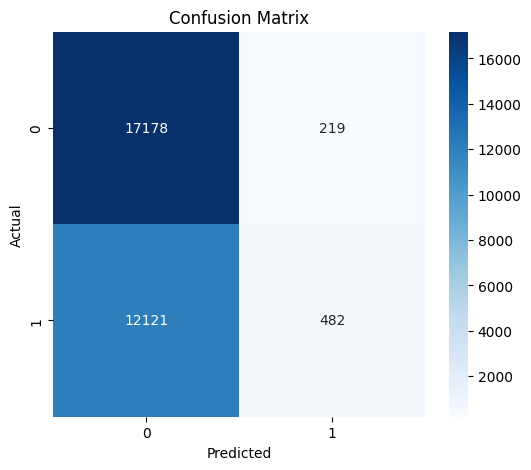

BATCH 20 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4129, Val Loss: 0.3790
Epoch 2/20, Train Loss: 0.3742, Val Loss: 0.3538
Epoch 3/20, Train Loss: 0.3518, Val Loss: 0.3338
Epoch 4/20, Train Loss: 0.3474, Val Loss: 0.3348
Epoch 5/20, Train Loss: 0.3422, Val Loss: 0.3298
Epoch 6/20, Train Loss: 0.3297, Val Loss: 0.3335
Epoch 7/20, Train Loss: 0.3346, Val Loss: 0.3248
Epoch 8/20, Train Loss: 0.3214, Val Loss: 0.3080
Epoch 9/20, Train Loss: 0.3127, Val Loss: 0.2966
Epoch 10/20, Train Loss: 0.3034, Val Loss: 0.2933
Epoch 11/20, Train Loss: 0.2890, Val Loss: 0.2765
Epoch 12/20, Train Loss: 0.2969, Val Loss: 0.2997
Epoch 13/20, Train Loss: 0.2989, Val Loss: 0.2917
Epoch 14/20, Train Loss: 0.2788, Val Loss: 0.2703
Epoch 15/20, Train Loss: 0.2668, Val Loss: 0.2543
Epoch 16/20, Train Loss: 0.2552, Val Loss: 0.2496
Epoch 17/20, Train Loss: 0.2523, Val Loss: 0.2364
Epoch 18/20, Train Loss: 0.2459, Val Loss: 0.2469
Epoch 19/20, Train Loss: 0.2382, Val Loss: 0.2295
Epoch 20/20, Tr

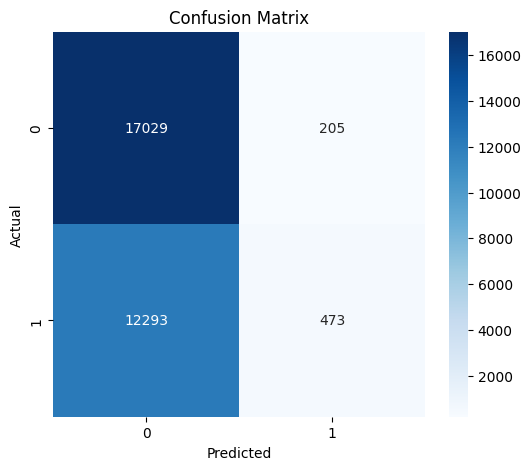

BATCH 21 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4367, Val Loss: 0.3853
Epoch 2/20, Train Loss: 0.3799, Val Loss: 0.3489
Epoch 3/20, Train Loss: 0.3577, Val Loss: 0.3376
Epoch 4/20, Train Loss: 0.3485, Val Loss: 0.3199
Epoch 5/20, Train Loss: 0.3201, Val Loss: 0.3042
Epoch 6/20, Train Loss: 0.3086, Val Loss: 0.2936
Epoch 7/20, Train Loss: 0.3077, Val Loss: 0.3005
Epoch 8/20, Train Loss: 0.3019, Val Loss: 0.2801
Epoch 9/20, Train Loss: 0.2953, Val Loss: 0.2674
Epoch 10/20, Train Loss: 0.2859, Val Loss: 0.2900
Epoch 11/20, Train Loss: 0.3012, Val Loss: 0.2807
Epoch 12/20, Train Loss: 0.2741, Val Loss: 0.2551
Epoch 13/20, Train Loss: 0.2675, Val Loss: 0.2443
Epoch 14/20, Train Loss: 0.2516, Val Loss: 0.2352
Epoch 15/20, Train Loss: 0.2372, Val Loss: 0.2264
Epoch 16/20, Train Loss: 0.2352, Val Loss: 0.2212
Epoch 17/20, Train Loss: 0.2322, Val Loss: 0.2317
Epoch 18/20, Train Loss: 0.2380, Val Loss: 0.2247
Epoch 19/20, Train Loss: 0.2272, Val Loss: 0.2281
Epoch 20/20, Tr

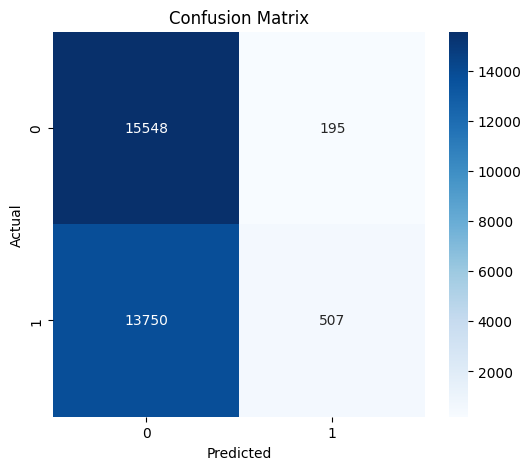

BATCH 22 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3990, Val Loss: 0.3520
Epoch 2/20, Train Loss: 0.3450, Val Loss: 0.3296
Epoch 3/20, Train Loss: 0.3266, Val Loss: 0.3197
Epoch 4/20, Train Loss: 0.3305, Val Loss: 0.3221
Epoch 5/20, Train Loss: 0.3189, Val Loss: 0.3158
Epoch 6/20, Train Loss: 0.3138, Val Loss: 0.2795
Epoch 7/20, Train Loss: 0.2823, Val Loss: 0.2680
Epoch 8/20, Train Loss: 0.2803, Val Loss: 0.2599
Epoch 9/20, Train Loss: 0.2661, Val Loss: 0.2564
Epoch 10/20, Train Loss: 0.2461, Val Loss: 0.2332
Epoch 11/20, Train Loss: 0.2602, Val Loss: 0.2446
Epoch 12/20, Train Loss: 0.2485, Val Loss: 0.2416
Epoch 13/20, Train Loss: 0.2436, Val Loss: 0.2235
Epoch 14/20, Train Loss: 0.2180, Val Loss: 0.2133
Epoch 15/20, Train Loss: 0.2316, Val Loss: 0.2079
Epoch 16/20, Train Loss: 0.2081, Val Loss: 0.1922
Epoch 17/20, Train Loss: 0.2189, Val Loss: 0.2005
Epoch 18/20, Train Loss: 0.2320, Val Loss: 0.2262
Epoch 19/20, Train Loss: 0.2243, Val Loss: 0.2243
Epoch 20/20, Tr

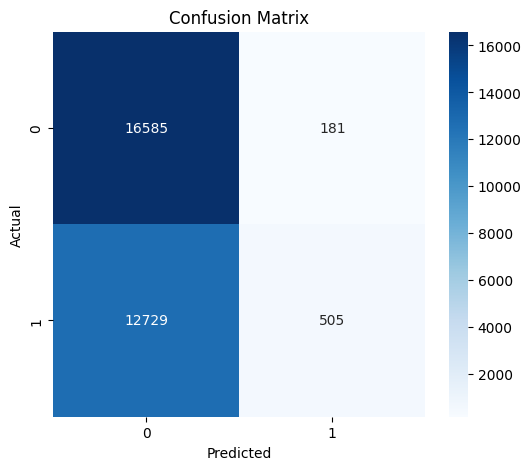

BATCH 23 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4253, Val Loss: 0.3669
Epoch 2/20, Train Loss: 0.3461, Val Loss: 0.3355
Epoch 3/20, Train Loss: 0.3250, Val Loss: 0.3112
Epoch 4/20, Train Loss: 0.3055, Val Loss: 0.3109
Epoch 5/20, Train Loss: 0.3067, Val Loss: 0.2917
Epoch 6/20, Train Loss: 0.2915, Val Loss: 0.2800
Epoch 7/20, Train Loss: 0.2895, Val Loss: 0.2725
Epoch 8/20, Train Loss: 0.2747, Val Loss: 0.2590
Epoch 9/20, Train Loss: 0.2710, Val Loss: 0.2525
Epoch 10/20, Train Loss: 0.2669, Val Loss: 0.2706
Epoch 11/20, Train Loss: 0.2858, Val Loss: 0.2571
Epoch 12/20, Train Loss: 0.2704, Val Loss: 0.2503
Epoch 13/20, Train Loss: 0.2697, Val Loss: 0.2425
Epoch 14/20, Train Loss: 0.2792, Val Loss: 0.2579
Epoch 15/20, Train Loss: 0.2626, Val Loss: 0.2539
Epoch 16/20, Train Loss: 0.2690, Val Loss: 0.2386
Epoch 17/20, Train Loss: 0.2478, Val Loss: 0.2219
Epoch 18/20, Train Loss: 0.2330, Val Loss: 0.2162
Epoch 19/20, Train Loss: 0.2224, Val Loss: 0.2044
Epoch 20/20, Tr

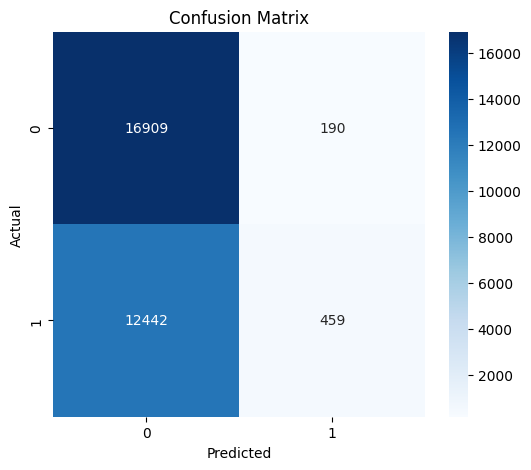

BATCH 24 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4027, Val Loss: 0.3515
Epoch 2/20, Train Loss: 0.3449, Val Loss: 0.3274
Epoch 3/20, Train Loss: 0.3271, Val Loss: 0.3213
Epoch 4/20, Train Loss: 0.3176, Val Loss: 0.2890
Epoch 5/20, Train Loss: 0.3001, Val Loss: 0.2876
Epoch 6/20, Train Loss: 0.2835, Val Loss: 0.2710
Epoch 7/20, Train Loss: 0.2849, Val Loss: 0.2629
Epoch 8/20, Train Loss: 0.2723, Val Loss: 0.2556
Epoch 9/20, Train Loss: 0.2555, Val Loss: 0.2392
Epoch 10/20, Train Loss: 0.2509, Val Loss: 0.2323
Epoch 11/20, Train Loss: 0.2620, Val Loss: 0.2580
Epoch 12/20, Train Loss: 0.2585, Val Loss: 0.2561
Epoch 13/20, Train Loss: 0.2473, Val Loss: 0.2387
Epoch 14/20, Train Loss: 0.2440, Val Loss: 0.2353
Epoch 15/20, Train Loss: 0.2447, Val Loss: 0.2309
Epoch 16/20, Train Loss: 0.2275, Val Loss: 0.2063
Epoch 17/20, Train Loss: 0.2264, Val Loss: 0.1960
Epoch 18/20, Train Loss: 0.2071, Val Loss: 0.1985
Epoch 19/20, Train Loss: 0.1977, Val Loss: 0.1953
Epoch 20/20, Tr

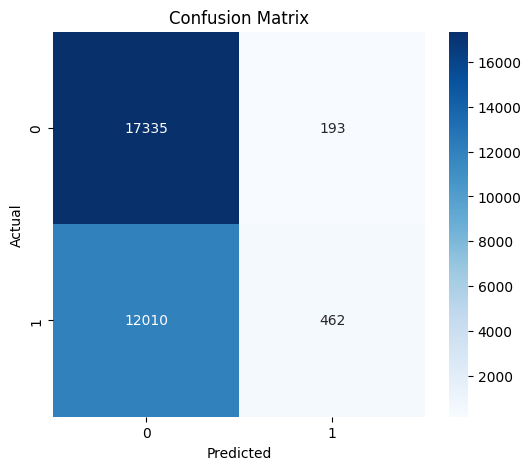

BATCH 25 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3816, Val Loss: 0.3416
Epoch 2/20, Train Loss: 0.3299, Val Loss: 0.3097
Epoch 3/20, Train Loss: 0.3031, Val Loss: 0.2828
Epoch 4/20, Train Loss: 0.2811, Val Loss: 0.2728
Epoch 5/20, Train Loss: 0.2692, Val Loss: 0.2660
Epoch 6/20, Train Loss: 0.2760, Val Loss: 0.2576
Epoch 7/20, Train Loss: 0.2748, Val Loss: 0.2569
Epoch 8/20, Train Loss: 0.2617, Val Loss: 0.2635
Epoch 9/20, Train Loss: 0.2564, Val Loss: 0.2490
Epoch 10/20, Train Loss: 0.2500, Val Loss: 0.2426
Epoch 11/20, Train Loss: 0.2507, Val Loss: 0.2503
Epoch 12/20, Train Loss: 0.2463, Val Loss: 0.2295
Epoch 13/20, Train Loss: 0.2326, Val Loss: 0.2192
Epoch 14/20, Train Loss: 0.2217, Val Loss: 0.2090
Epoch 15/20, Train Loss: 0.2230, Val Loss: 0.2087
Epoch 16/20, Train Loss: 0.2369, Val Loss: 0.2148
Epoch 17/20, Train Loss: 0.2152, Val Loss: 0.2050
Epoch 18/20, Train Loss: 0.2080, Val Loss: 0.2018
Epoch 19/20, Train Loss: 0.2174, Val Loss: 0.2157
Epoch 20/20, Tr

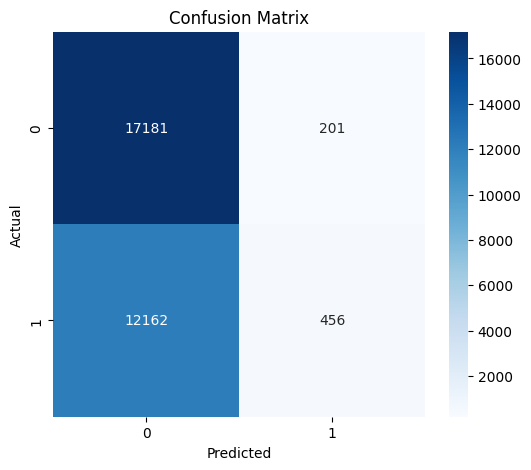

BATCH 26 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4139, Val Loss: 0.3545
Epoch 2/20, Train Loss: 0.3224, Val Loss: 0.3091
Epoch 3/20, Train Loss: 0.3033, Val Loss: 0.2985
Epoch 4/20, Train Loss: 0.3027, Val Loss: 0.2991
Epoch 5/20, Train Loss: 0.2955, Val Loss: 0.2754
Epoch 6/20, Train Loss: 0.2800, Val Loss: 0.2584
Epoch 7/20, Train Loss: 0.2617, Val Loss: 0.2418
Epoch 8/20, Train Loss: 0.2566, Val Loss: 0.2355
Epoch 9/20, Train Loss: 0.2511, Val Loss: 0.2422
Epoch 10/20, Train Loss: 0.2544, Val Loss: 0.2279
Epoch 11/20, Train Loss: 0.2372, Val Loss: 0.2261
Epoch 12/20, Train Loss: 0.2139, Val Loss: 0.2039
Epoch 13/20, Train Loss: 0.2268, Val Loss: 0.1991
Epoch 14/20, Train Loss: 0.2169, Val Loss: 0.1917
Epoch 15/20, Train Loss: 0.1968, Val Loss: 0.1777
Epoch 16/20, Train Loss: 0.1879, Val Loss: 0.1822
Epoch 17/20, Train Loss: 0.1877, Val Loss: 0.1920
Epoch 18/20, Train Loss: 0.2052, Val Loss: 0.1936
Epoch 19/20, Train Loss: 0.1973, Val Loss: 0.1758
Epoch 20/20, Tr

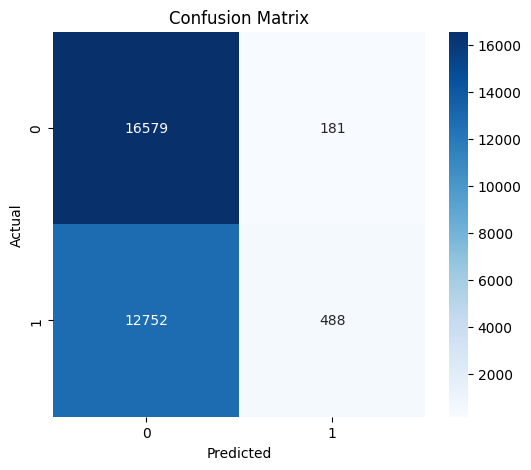

BATCH 27 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4472, Val Loss: 0.3600
Epoch 2/20, Train Loss: 0.3675, Val Loss: 0.3342
Epoch 3/20, Train Loss: 0.3346, Val Loss: 0.3299
Epoch 4/20, Train Loss: 0.3291, Val Loss: 0.3109
Epoch 5/20, Train Loss: 0.3061, Val Loss: 0.2945
Epoch 6/20, Train Loss: 0.2939, Val Loss: 0.2933
Epoch 7/20, Train Loss: 0.2859, Val Loss: 0.2645
Epoch 8/20, Train Loss: 0.2782, Val Loss: 0.2592
Epoch 9/20, Train Loss: 0.2702, Val Loss: 0.2513
Epoch 10/20, Train Loss: 0.2604, Val Loss: 0.2446
Epoch 11/20, Train Loss: 0.2551, Val Loss: 0.2541
Epoch 12/20, Train Loss: 0.2673, Val Loss: 0.2371
Epoch 13/20, Train Loss: 0.2492, Val Loss: 0.2332
Epoch 14/20, Train Loss: 0.2337, Val Loss: 0.2157
Epoch 15/20, Train Loss: 0.2256, Val Loss: 0.2430
Epoch 16/20, Train Loss: 0.2300, Val Loss: 0.2105
Epoch 17/20, Train Loss: 0.2129, Val Loss: 0.2056
Epoch 18/20, Train Loss: 0.2213, Val Loss: 0.2295
Epoch 19/20, Train Loss: 0.2241, Val Loss: 0.2293
Epoch 20/20, Tr

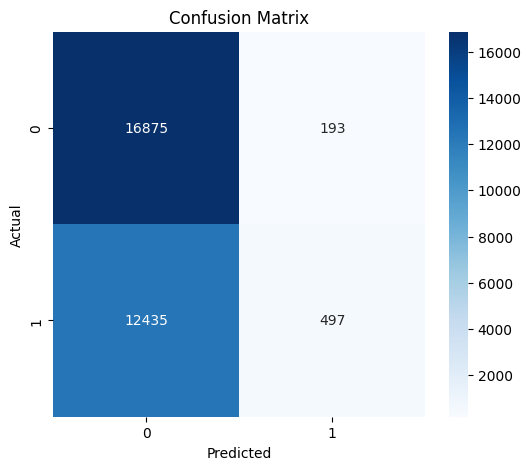

BATCH 28 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4667, Val Loss: 0.3803
Epoch 2/20, Train Loss: 0.3593, Val Loss: 0.3358
Epoch 3/20, Train Loss: 0.3307, Val Loss: 0.3159
Epoch 4/20, Train Loss: 0.3192, Val Loss: 0.2943
Epoch 5/20, Train Loss: 0.2946, Val Loss: 0.2842
Epoch 6/20, Train Loss: 0.2874, Val Loss: 0.2706
Epoch 7/20, Train Loss: 0.2695, Val Loss: 0.2544
Epoch 8/20, Train Loss: 0.2585, Val Loss: 0.2454
Epoch 9/20, Train Loss: 0.2543, Val Loss: 0.2341
Epoch 10/20, Train Loss: 0.2441, Val Loss: 0.2297
Epoch 11/20, Train Loss: 0.2387, Val Loss: 0.2198
Epoch 12/20, Train Loss: 0.2358, Val Loss: 0.2077
Epoch 13/20, Train Loss: 0.2324, Val Loss: 0.2175
Epoch 14/20, Train Loss: 0.2217, Val Loss: 0.1988
Epoch 15/20, Train Loss: 0.2208, Val Loss: 0.2168
Epoch 16/20, Train Loss: 0.2087, Val Loss: 0.2224
Epoch 17/20, Train Loss: 0.2112, Val Loss: 0.1932
Epoch 18/20, Train Loss: 0.2073, Val Loss: 0.1845
Epoch 19/20, Train Loss: 0.1955, Val Loss: 0.1886
Epoch 20/20, Tr

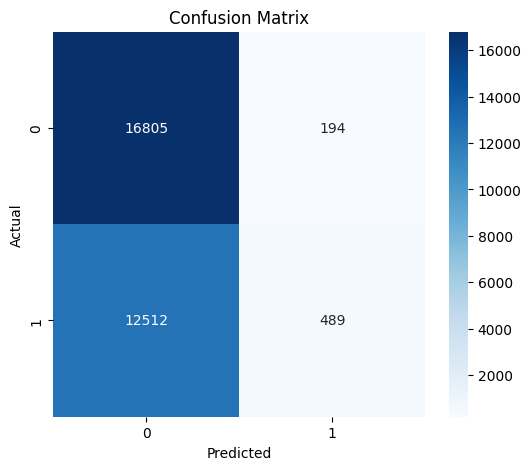

BATCH 29 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4906, Val Loss: 0.3903
Epoch 2/20, Train Loss: 0.3822, Val Loss: 0.3780
Epoch 3/20, Train Loss: 0.3746, Val Loss: 0.3472
Epoch 4/20, Train Loss: 0.3402, Val Loss: 0.3222
Epoch 5/20, Train Loss: 0.3239, Val Loss: 0.3061
Epoch 6/20, Train Loss: 0.3167, Val Loss: 0.3010
Epoch 7/20, Train Loss: 0.3023, Val Loss: 0.2803
Epoch 8/20, Train Loss: 0.2950, Val Loss: 0.2796
Epoch 9/20, Train Loss: 0.2870, Val Loss: 0.2637
Epoch 10/20, Train Loss: 0.2899, Val Loss: 0.2816
Epoch 11/20, Train Loss: 0.2809, Val Loss: 0.2754
Epoch 12/20, Train Loss: 0.2786, Val Loss: 0.2460
Epoch 13/20, Train Loss: 0.2485, Val Loss: 0.2327
Epoch 14/20, Train Loss: 0.2455, Val Loss: 0.2198
Epoch 15/20, Train Loss: 0.2372, Val Loss: 0.2405
Epoch 16/20, Train Loss: 0.2392, Val Loss: 0.2221
Epoch 17/20, Train Loss: 0.2305, Val Loss: 0.2305
Epoch 18/20, Train Loss: 0.2210, Val Loss: 0.2193
Epoch 19/20, Train Loss: 0.2187, Val Loss: 0.2071
Epoch 20/20, Tr

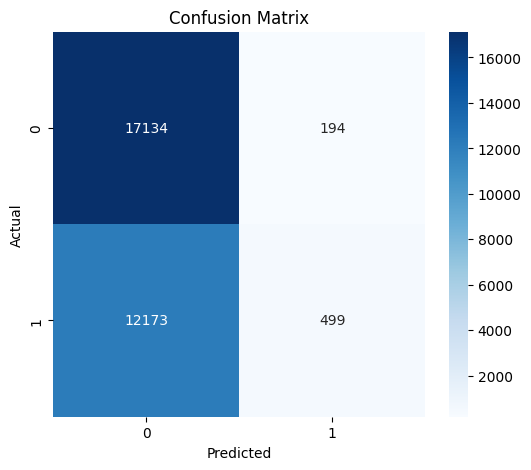

BATCH 30 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4294, Val Loss: 0.3685
Epoch 2/20, Train Loss: 0.3494, Val Loss: 0.3394
Epoch 3/20, Train Loss: 0.3487, Val Loss: 0.3381
Epoch 4/20, Train Loss: 0.3278, Val Loss: 0.3066
Epoch 5/20, Train Loss: 0.3221, Val Loss: 0.3059
Epoch 6/20, Train Loss: 0.3148, Val Loss: 0.2929
Epoch 7/20, Train Loss: 0.3005, Val Loss: 0.2887
Epoch 8/20, Train Loss: 0.2816, Val Loss: 0.2927
Epoch 9/20, Train Loss: 0.2800, Val Loss: 0.2754
Epoch 10/20, Train Loss: 0.2706, Val Loss: 0.2640
Epoch 11/20, Train Loss: 0.2660, Val Loss: 0.2507
Epoch 12/20, Train Loss: 0.2766, Val Loss: 0.2486
Epoch 13/20, Train Loss: 0.2842, Val Loss: 0.2642
Epoch 14/20, Train Loss: 0.2538, Val Loss: 0.2429
Epoch 15/20, Train Loss: 0.2551, Val Loss: 0.2334
Epoch 16/20, Train Loss: 0.2470, Val Loss: 0.2376
Epoch 17/20, Train Loss: 0.2346, Val Loss: 0.2328
Epoch 18/20, Train Loss: 0.2289, Val Loss: 0.2235
Epoch 19/20, Train Loss: 0.2337, Val Loss: 0.2158
Epoch 20/20, Tr

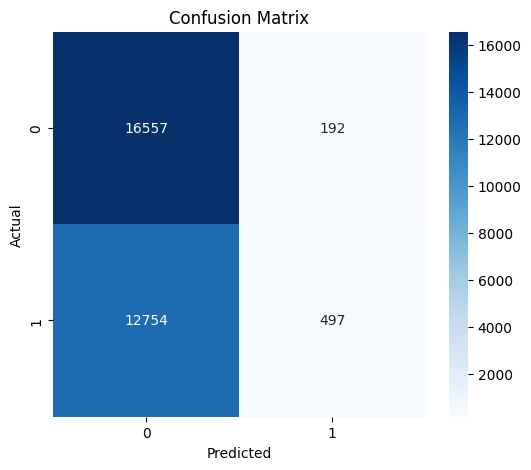

BATCH 31 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4758, Val Loss: 0.3760
Epoch 2/20, Train Loss: 0.3602, Val Loss: 0.3495
Epoch 3/20, Train Loss: 0.3304, Val Loss: 0.3166
Epoch 4/20, Train Loss: 0.3192, Val Loss: 0.3201
Epoch 5/20, Train Loss: 0.3143, Val Loss: 0.2952
Epoch 6/20, Train Loss: 0.2943, Val Loss: 0.2804
Epoch 7/20, Train Loss: 0.2869, Val Loss: 0.2660
Epoch 8/20, Train Loss: 0.2776, Val Loss: 0.2634
Epoch 9/20, Train Loss: 0.2986, Val Loss: 0.2692
Epoch 10/20, Train Loss: 0.2930, Val Loss: 0.2649
Epoch 11/20, Train Loss: 0.2702, Val Loss: 0.2517
Epoch 12/20, Train Loss: 0.2628, Val Loss: 0.2385
Epoch 13/20, Train Loss: 0.2463, Val Loss: 0.2285
Epoch 14/20, Train Loss: 0.2305, Val Loss: 0.2160
Epoch 15/20, Train Loss: 0.2288, Val Loss: 0.2152
Epoch 16/20, Train Loss: 0.2262, Val Loss: 0.2008
Epoch 17/20, Train Loss: 0.2191, Val Loss: 0.1999
Epoch 18/20, Train Loss: 0.2289, Val Loss: 0.2260
Epoch 19/20, Train Loss: 0.2274, Val Loss: 0.2142
Epoch 20/20, Tr

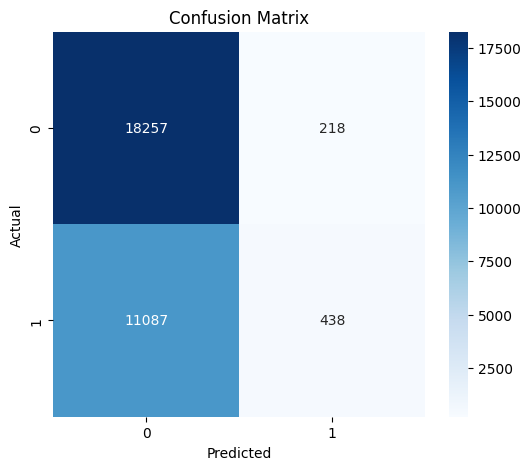

BATCH 32 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3907, Val Loss: 0.3089
Epoch 2/20, Train Loss: 0.3205, Val Loss: 0.2894
Epoch 3/20, Train Loss: 0.2842, Val Loss: 0.2589
Epoch 4/20, Train Loss: 0.2678, Val Loss: 0.2567
Epoch 5/20, Train Loss: 0.2540, Val Loss: 0.2307
Epoch 6/20, Train Loss: 0.2350, Val Loss: 0.2192
Epoch 7/20, Train Loss: 0.2248, Val Loss: 0.2188
Epoch 8/20, Train Loss: 0.2299, Val Loss: 0.2181
Epoch 9/20, Train Loss: 0.2263, Val Loss: 0.2002
Epoch 10/20, Train Loss: 0.2099, Val Loss: 0.2077
Epoch 11/20, Train Loss: 0.2190, Val Loss: 0.2002
Epoch 12/20, Train Loss: 0.2225, Val Loss: 0.2095
Epoch 13/20, Train Loss: 0.2058, Val Loss: 0.1957
Epoch 14/20, Train Loss: 0.1989, Val Loss: 0.1965
Epoch 15/20, Train Loss: 0.1976, Val Loss: 0.1719
Epoch 16/20, Train Loss: 0.1740, Val Loss: 0.1637
Epoch 17/20, Train Loss: 0.1759, Val Loss: 0.1617
Epoch 18/20, Train Loss: 0.1775, Val Loss: 0.1863
Epoch 19/20, Train Loss: 0.1763, Val Loss: 0.1673
Epoch 20/20, Tr

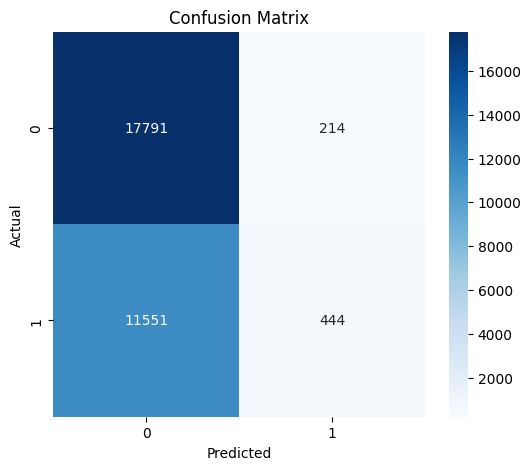

BATCH 33 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4541, Val Loss: 0.3532
Epoch 2/20, Train Loss: 0.3485, Val Loss: 0.3261
Epoch 3/20, Train Loss: 0.3088, Val Loss: 0.2993
Epoch 4/20, Train Loss: 0.2991, Val Loss: 0.2916
Epoch 5/20, Train Loss: 0.3033, Val Loss: 0.2797
Epoch 6/20, Train Loss: 0.2759, Val Loss: 0.2581
Epoch 7/20, Train Loss: 0.2660, Val Loss: 0.2595
Epoch 8/20, Train Loss: 0.2576, Val Loss: 0.2299
Epoch 9/20, Train Loss: 0.2493, Val Loss: 0.2270
Epoch 10/20, Train Loss: 0.2502, Val Loss: 0.2342
Epoch 11/20, Train Loss: 0.2252, Val Loss: 0.2150
Epoch 12/20, Train Loss: 0.2174, Val Loss: 0.2110
Epoch 13/20, Train Loss: 0.2237, Val Loss: 0.2357
Epoch 14/20, Train Loss: 0.2372, Val Loss: 0.2210
Epoch 15/20, Train Loss: 0.2107, Val Loss: 0.1998
Epoch 16/20, Train Loss: 0.2011, Val Loss: 0.1936
Epoch 17/20, Train Loss: 0.1988, Val Loss: 0.1920
Epoch 18/20, Train Loss: 0.2021, Val Loss: 0.1876
Epoch 19/20, Train Loss: 0.1995, Val Loss: 0.1950
Epoch 20/20, Tr

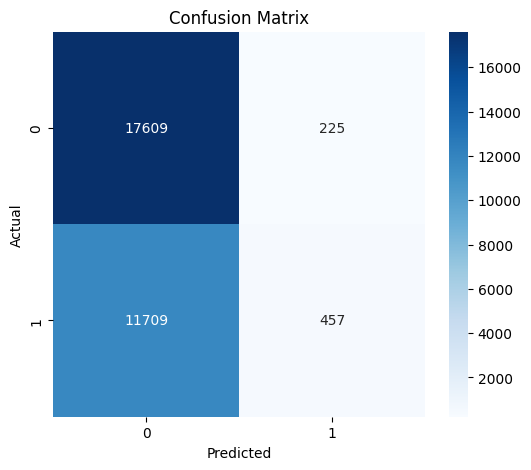

BATCH 34 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4348, Val Loss: 0.3685
Epoch 2/20, Train Loss: 0.3731, Val Loss: 0.3676
Epoch 3/20, Train Loss: 0.3440, Val Loss: 0.3193
Epoch 4/20, Train Loss: 0.3245, Val Loss: 0.3029
Epoch 5/20, Train Loss: 0.2983, Val Loss: 0.2762
Epoch 6/20, Train Loss: 0.2879, Val Loss: 0.2717
Epoch 7/20, Train Loss: 0.2728, Val Loss: 0.2633
Epoch 8/20, Train Loss: 0.2643, Val Loss: 0.2435
Epoch 9/20, Train Loss: 0.2526, Val Loss: 0.2424
Epoch 10/20, Train Loss: 0.2586, Val Loss: 0.2325
Epoch 11/20, Train Loss: 0.2429, Val Loss: 0.2442
Epoch 12/20, Train Loss: 0.2535, Val Loss: 0.2603
Epoch 13/20, Train Loss: 0.2463, Val Loss: 0.2133
Epoch 14/20, Train Loss: 0.2288, Val Loss: 0.2155
Epoch 15/20, Train Loss: 0.2144, Val Loss: 0.2016
Epoch 16/20, Train Loss: 0.1987, Val Loss: 0.2071
Epoch 17/20, Train Loss: 0.2103, Val Loss: 0.2182
Epoch 18/20, Train Loss: 0.2386, Val Loss: 0.2341
Epoch 19/20, Train Loss: 0.2379, Val Loss: 0.2171
Epoch 20/20, Tr

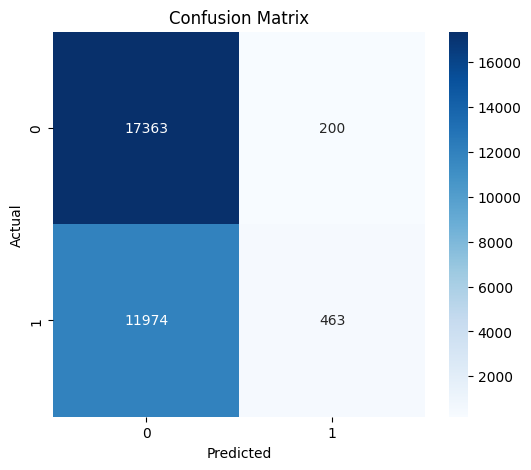

BATCH 35 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4238, Val Loss: 0.3599
Epoch 2/20, Train Loss: 0.3559, Val Loss: 0.3344
Epoch 3/20, Train Loss: 0.3359, Val Loss: 0.3068
Epoch 4/20, Train Loss: 0.3103, Val Loss: 0.2857
Epoch 5/20, Train Loss: 0.2993, Val Loss: 0.2916
Epoch 6/20, Train Loss: 0.2832, Val Loss: 0.2845
Epoch 7/20, Train Loss: 0.2781, Val Loss: 0.2719
Epoch 8/20, Train Loss: 0.2824, Val Loss: 0.3410
Epoch 9/20, Train Loss: 0.3234, Val Loss: 0.2803
Epoch 10/20, Train Loss: 0.2818, Val Loss: 0.2682
Epoch 11/20, Train Loss: 0.2700, Val Loss: 0.2488
Epoch 12/20, Train Loss: 0.2586, Val Loss: 0.2571
Epoch 13/20, Train Loss: 0.2508, Val Loss: 0.2533
Epoch 14/20, Train Loss: 0.2543, Val Loss: 0.2308
Epoch 15/20, Train Loss: 0.2318, Val Loss: 0.2300
Epoch 16/20, Train Loss: 0.2305, Val Loss: 0.2157
Epoch 17/20, Train Loss: 0.2451, Val Loss: 0.2164
Epoch 18/20, Train Loss: 0.2326, Val Loss: 0.1997
Epoch 19/20, Train Loss: 0.2179, Val Loss: 0.2026
Epoch 20/20, Tr

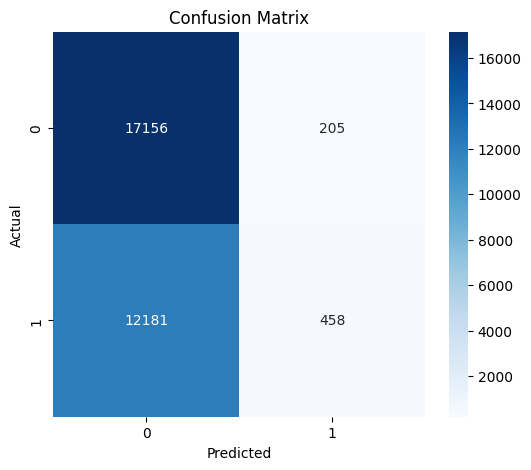

BATCH 36 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4355, Val Loss: 0.3702
Epoch 2/20, Train Loss: 0.3496, Val Loss: 0.3170
Epoch 3/20, Train Loss: 0.3203, Val Loss: 0.2985
Epoch 4/20, Train Loss: 0.2993, Val Loss: 0.2926
Epoch 5/20, Train Loss: 0.2898, Val Loss: 0.2705
Epoch 6/20, Train Loss: 0.2690, Val Loss: 0.2504
Epoch 7/20, Train Loss: 0.2558, Val Loss: 0.2400
Epoch 8/20, Train Loss: 0.2422, Val Loss: 0.2229
Epoch 9/20, Train Loss: 0.2361, Val Loss: 0.2369
Epoch 10/20, Train Loss: 0.2278, Val Loss: 0.2359
Epoch 11/20, Train Loss: 0.2370, Val Loss: 0.2160
Epoch 12/20, Train Loss: 0.2419, Val Loss: 0.2204
Epoch 13/20, Train Loss: 0.2365, Val Loss: 0.2390
Epoch 14/20, Train Loss: 0.2130, Val Loss: 0.2060
Epoch 15/20, Train Loss: 0.2022, Val Loss: 0.1837
Epoch 16/20, Train Loss: 0.1836, Val Loss: 0.1738
Epoch 17/20, Train Loss: 0.1824, Val Loss: 0.1741
Epoch 18/20, Train Loss: 0.1806, Val Loss: 0.1727
Epoch 19/20, Train Loss: 0.1922, Val Loss: 0.1711
Epoch 20/20, Tr

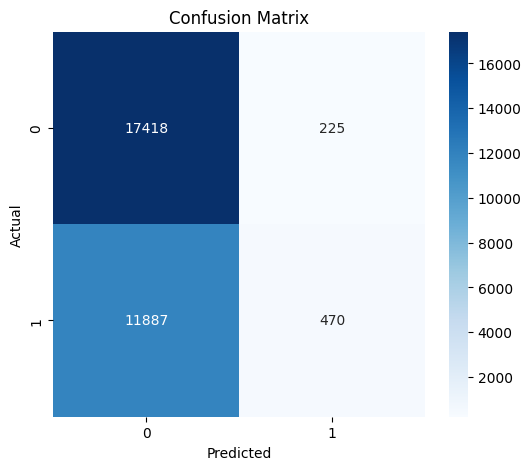

BATCH 37 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.5200, Val Loss: 0.4303
Epoch 2/20, Train Loss: 0.4031, Val Loss: 0.3570
Epoch 3/20, Train Loss: 0.3566, Val Loss: 0.3337
Epoch 4/20, Train Loss: 0.3289, Val Loss: 0.3159
Epoch 5/20, Train Loss: 0.3214, Val Loss: 0.2964
Epoch 6/20, Train Loss: 0.3146, Val Loss: 0.2972
Epoch 7/20, Train Loss: 0.3019, Val Loss: 0.2825
Epoch 8/20, Train Loss: 0.2866, Val Loss: 0.2780
Epoch 9/20, Train Loss: 0.2763, Val Loss: 0.2761
Epoch 10/20, Train Loss: 0.2824, Val Loss: 0.2658
Epoch 11/20, Train Loss: 0.2644, Val Loss: 0.2491
Epoch 12/20, Train Loss: 0.2624, Val Loss: 0.2468
Epoch 13/20, Train Loss: 0.2502, Val Loss: 0.2336
Epoch 14/20, Train Loss: 0.2524, Val Loss: 0.2523
Epoch 15/20, Train Loss: 0.2419, Val Loss: 0.2275
Epoch 16/20, Train Loss: 0.2394, Val Loss: 0.2282
Epoch 17/20, Train Loss: 0.2197, Val Loss: 0.2064
Epoch 18/20, Train Loss: 0.2166, Val Loss: 0.1998
Epoch 19/20, Train Loss: 0.2147, Val Loss: 0.2026
Epoch 20/20, Tr

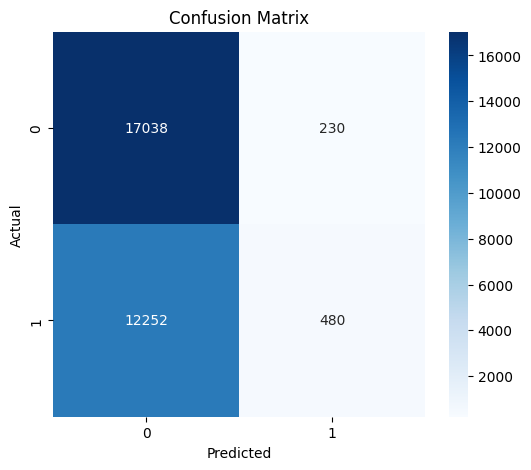

BATCH 38 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4397, Val Loss: 0.3703
Epoch 2/20, Train Loss: 0.3759, Val Loss: 0.3282
Epoch 3/20, Train Loss: 0.3265, Val Loss: 0.3049
Epoch 4/20, Train Loss: 0.3212, Val Loss: 0.3145
Epoch 5/20, Train Loss: 0.3084, Val Loss: 0.2987
Epoch 6/20, Train Loss: 0.2963, Val Loss: 0.2774
Epoch 7/20, Train Loss: 0.2836, Val Loss: 0.2596
Epoch 8/20, Train Loss: 0.2737, Val Loss: 0.2544
Epoch 9/20, Train Loss: 0.2605, Val Loss: 0.2428
Epoch 10/20, Train Loss: 0.2556, Val Loss: 0.2474
Epoch 11/20, Train Loss: 0.2451, Val Loss: 0.2271
Epoch 12/20, Train Loss: 0.2334, Val Loss: 0.2172
Epoch 13/20, Train Loss: 0.2419, Val Loss: 0.2427
Epoch 14/20, Train Loss: 0.2283, Val Loss: 0.2271
Epoch 15/20, Train Loss: 0.2194, Val Loss: 0.2047
Epoch 16/20, Train Loss: 0.2211, Val Loss: 0.2124
Epoch 17/20, Train Loss: 0.2287, Val Loss: 0.2129
Epoch 18/20, Train Loss: 0.2224, Val Loss: 0.2005
Epoch 19/20, Train Loss: 0.2709, Val Loss: 0.2796
Epoch 20/20, Tr

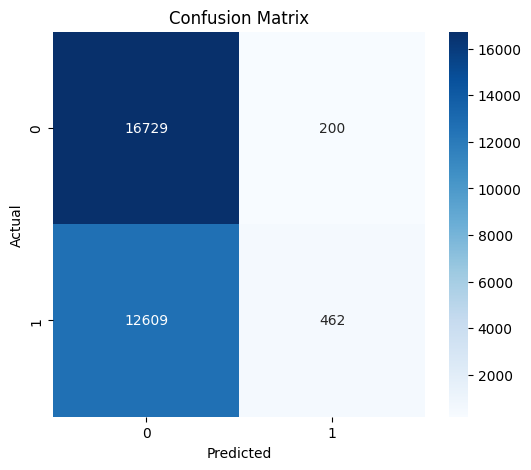

BATCH 39 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.3842, Val Loss: 0.3583
Epoch 2/20, Train Loss: 0.3541, Val Loss: 0.3200
Epoch 3/20, Train Loss: 0.3129, Val Loss: 0.3091
Epoch 4/20, Train Loss: 0.3088, Val Loss: 0.2899
Epoch 5/20, Train Loss: 0.2935, Val Loss: 0.2865
Epoch 6/20, Train Loss: 0.2879, Val Loss: 0.2613
Epoch 7/20, Train Loss: 0.2755, Val Loss: 0.2593
Epoch 8/20, Train Loss: 0.2544, Val Loss: 0.2421
Epoch 9/20, Train Loss: 0.2438, Val Loss: 0.2337
Epoch 10/20, Train Loss: 0.2433, Val Loss: 0.2505
Epoch 11/20, Train Loss: 0.2409, Val Loss: 0.2230
Epoch 12/20, Train Loss: 0.2313, Val Loss: 0.2167
Epoch 13/20, Train Loss: 0.2250, Val Loss: 0.2167
Epoch 14/20, Train Loss: 0.2258, Val Loss: 0.2234
Epoch 15/20, Train Loss: 0.2446, Val Loss: 0.2124
Epoch 16/20, Train Loss: 0.2215, Val Loss: 0.2041
Epoch 17/20, Train Loss: 0.2093, Val Loss: 0.1964
Epoch 18/20, Train Loss: 0.2005, Val Loss: 0.1949
Epoch 19/20, Train Loss: 0.2127, Val Loss: 0.2071
Epoch 20/20, Tr

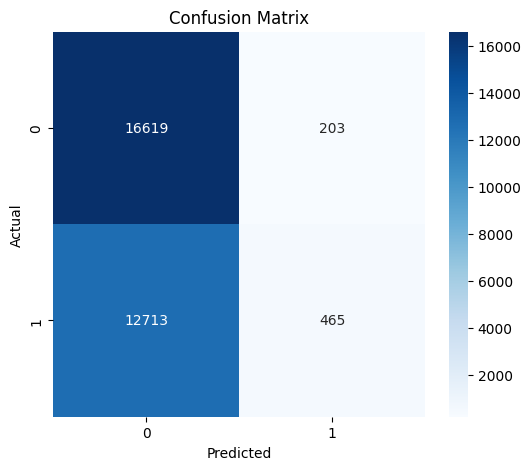

BATCH 40 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4335, Val Loss: 0.3510
Epoch 2/20, Train Loss: 0.3461, Val Loss: 0.3230
Epoch 3/20, Train Loss: 0.3148, Val Loss: 0.2958
Epoch 4/20, Train Loss: 0.3015, Val Loss: 0.2816
Epoch 5/20, Train Loss: 0.2958, Val Loss: 0.2769
Epoch 6/20, Train Loss: 0.2692, Val Loss: 0.2541
Epoch 7/20, Train Loss: 0.2522, Val Loss: 0.2479
Epoch 8/20, Train Loss: 0.2554, Val Loss: 0.2476
Epoch 9/20, Train Loss: 0.2735, Val Loss: 0.2837
Epoch 10/20, Train Loss: 0.2791, Val Loss: 0.2595
Epoch 11/20, Train Loss: 0.2483, Val Loss: 0.2269
Epoch 12/20, Train Loss: 0.2380, Val Loss: 0.2216
Epoch 13/20, Train Loss: 0.2242, Val Loss: 0.2095
Epoch 14/20, Train Loss: 0.2228, Val Loss: 0.2293
Epoch 15/20, Train Loss: 0.2292, Val Loss: 0.2387
Epoch 16/20, Train Loss: 0.2437, Val Loss: 0.2211
Epoch 17/20, Train Loss: 0.2368, Val Loss: 0.2022
Epoch 18/20, Train Loss: 0.2280, Val Loss: 0.1912
Epoch 19/20, Train Loss: 0.1940, Val Loss: 0.1936
Epoch 20/20, Tr

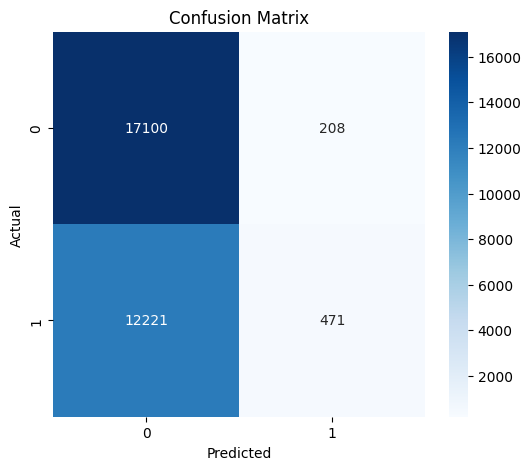

BATCH 41 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4181, Val Loss: 0.3473
Epoch 2/20, Train Loss: 0.3555, Val Loss: 0.3312
Epoch 3/20, Train Loss: 0.3245, Val Loss: 0.3093
Epoch 4/20, Train Loss: 0.3194, Val Loss: 0.3048
Epoch 5/20, Train Loss: 0.3057, Val Loss: 0.2893
Epoch 6/20, Train Loss: 0.2997, Val Loss: 0.2844
Epoch 7/20, Train Loss: 0.2818, Val Loss: 0.2837
Epoch 8/20, Train Loss: 0.2749, Val Loss: 0.2675
Epoch 9/20, Train Loss: 0.2595, Val Loss: 0.2464
Epoch 10/20, Train Loss: 0.2425, Val Loss: 0.2227
Epoch 11/20, Train Loss: 0.2337, Val Loss: 0.2229
Epoch 12/20, Train Loss: 0.2287, Val Loss: 0.2182
Epoch 13/20, Train Loss: 0.2274, Val Loss: 0.2131
Epoch 14/20, Train Loss: 0.2129, Val Loss: 0.2072
Epoch 15/20, Train Loss: 0.2128, Val Loss: 0.2069
Epoch 16/20, Train Loss: 0.2147, Val Loss: 0.2107
Epoch 17/20, Train Loss: 0.2164, Val Loss: 0.2574
Epoch 18/20, Train Loss: 0.2523, Val Loss: 0.2293
Epoch 19/20, Train Loss: 0.2390, Val Loss: 0.2165
Epoch 20/20, Tr

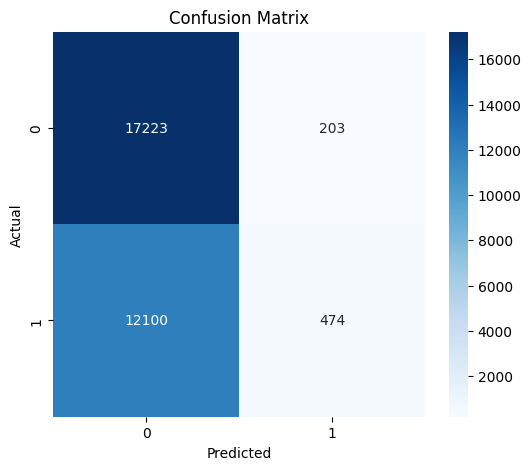

BATCH 42 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4544, Val Loss: 0.3925
Epoch 2/20, Train Loss: 0.3825, Val Loss: 0.3673
Epoch 3/20, Train Loss: 0.3712, Val Loss: 0.3439
Epoch 4/20, Train Loss: 0.3352, Val Loss: 0.3325
Epoch 5/20, Train Loss: 0.3446, Val Loss: 0.3085
Epoch 6/20, Train Loss: 0.3203, Val Loss: 0.3023
Epoch 7/20, Train Loss: 0.3000, Val Loss: 0.2830
Epoch 8/20, Train Loss: 0.2912, Val Loss: 0.2759
Epoch 9/20, Train Loss: 0.2771, Val Loss: 0.2642
Epoch 10/20, Train Loss: 0.2753, Val Loss: 0.2645
Epoch 11/20, Train Loss: 0.2724, Val Loss: 0.2640
Epoch 12/20, Train Loss: 0.2618, Val Loss: 0.2462
Epoch 13/20, Train Loss: 0.2518, Val Loss: 0.2457
Epoch 14/20, Train Loss: 0.2481, Val Loss: 0.2323
Epoch 15/20, Train Loss: 0.2468, Val Loss: 0.2452
Epoch 16/20, Train Loss: 0.2662, Val Loss: 0.2573
Epoch 17/20, Train Loss: 0.2549, Val Loss: 0.2448
Epoch 18/20, Train Loss: 0.2472, Val Loss: 0.2216
Epoch 19/20, Train Loss: 0.2680, Val Loss: 0.2761
Epoch 20/20, Tr

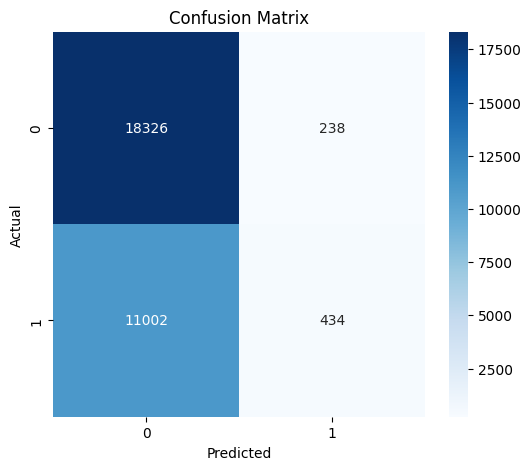

BATCH 43 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4341, Val Loss: 0.3634
Epoch 2/20, Train Loss: 0.3575, Val Loss: 0.3430
Epoch 3/20, Train Loss: 0.3351, Val Loss: 0.3262
Epoch 4/20, Train Loss: 0.3126, Val Loss: 0.3135
Epoch 5/20, Train Loss: 0.3117, Val Loss: 0.2873
Epoch 6/20, Train Loss: 0.2993, Val Loss: 0.2732
Epoch 7/20, Train Loss: 0.2896, Val Loss: 0.2731
Epoch 8/20, Train Loss: 0.2654, Val Loss: 0.2513
Epoch 9/20, Train Loss: 0.2611, Val Loss: 0.2436
Epoch 10/20, Train Loss: 0.2482, Val Loss: 0.2497
Epoch 11/20, Train Loss: 0.2399, Val Loss: 0.2402
Epoch 12/20, Train Loss: 0.2396, Val Loss: 0.2466
Epoch 13/20, Train Loss: 0.2240, Val Loss: 0.2249
Epoch 14/20, Train Loss: 0.2388, Val Loss: 0.2276
Epoch 15/20, Train Loss: 0.2305, Val Loss: 0.2088
Epoch 16/20, Train Loss: 0.2137, Val Loss: 0.2149
Epoch 17/20, Train Loss: 0.2313, Val Loss: 0.2142
Epoch 18/20, Train Loss: 0.2305, Val Loss: 0.2173
Epoch 19/20, Train Loss: 0.2208, Val Loss: 0.1944
Epoch 20/20, Tr

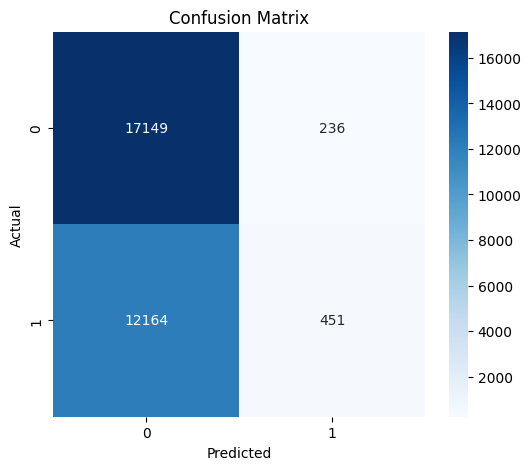

BATCH 44 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4569, Val Loss: 0.4041
Epoch 2/20, Train Loss: 0.3784, Val Loss: 0.3548
Epoch 3/20, Train Loss: 0.3461, Val Loss: 0.3402
Epoch 4/20, Train Loss: 0.3303, Val Loss: 0.3160
Epoch 5/20, Train Loss: 0.3139, Val Loss: 0.3077
Epoch 6/20, Train Loss: 0.3038, Val Loss: 0.2857
Epoch 7/20, Train Loss: 0.2892, Val Loss: 0.2709
Epoch 8/20, Train Loss: 0.2834, Val Loss: 0.2582
Epoch 9/20, Train Loss: 0.2690, Val Loss: 0.2763
Epoch 10/20, Train Loss: 0.2635, Val Loss: 0.2636
Epoch 11/20, Train Loss: 0.2576, Val Loss: 0.2369
Epoch 12/20, Train Loss: 0.2430, Val Loss: 0.2363
Epoch 13/20, Train Loss: 0.2347, Val Loss: 0.2457
Epoch 14/20, Train Loss: 0.2611, Val Loss: 0.2669
Epoch 15/20, Train Loss: 0.2568, Val Loss: 0.2412
Epoch 16/20, Train Loss: 0.2483, Val Loss: 0.2399
Epoch 17/20, Train Loss: 0.2623, Val Loss: 0.2587
Epoch 18/20, Train Loss: 0.2481, Val Loss: 0.2317
Epoch 19/20, Train Loss: 0.2284, Val Loss: 0.2186
Epoch 20/20, Tr

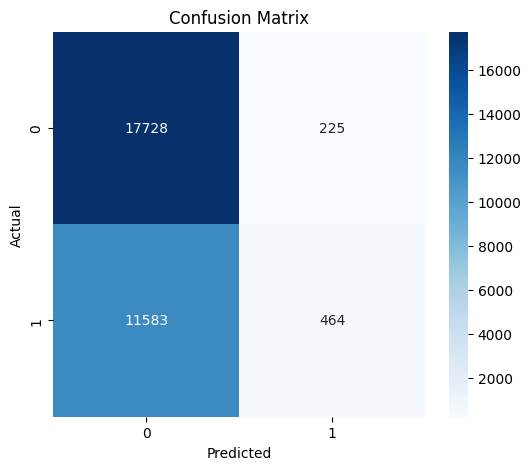

BATCH 45 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4301, Val Loss: 0.3443
Epoch 2/20, Train Loss: 0.3417, Val Loss: 0.3402
Epoch 3/20, Train Loss: 0.3148, Val Loss: 0.2908
Epoch 4/20, Train Loss: 0.2993, Val Loss: 0.2741
Epoch 5/20, Train Loss: 0.2795, Val Loss: 0.2683
Epoch 6/20, Train Loss: 0.2667, Val Loss: 0.2585
Epoch 7/20, Train Loss: 0.2535, Val Loss: 0.2346
Epoch 8/20, Train Loss: 0.2546, Val Loss: 0.2259
Epoch 9/20, Train Loss: 0.2498, Val Loss: 0.2305
Epoch 10/20, Train Loss: 0.2440, Val Loss: 0.2316
Epoch 11/20, Train Loss: 0.2342, Val Loss: 0.2136
Epoch 12/20, Train Loss: 0.2236, Val Loss: 0.2315
Epoch 13/20, Train Loss: 0.2380, Val Loss: 0.2360
Epoch 14/20, Train Loss: 0.2267, Val Loss: 0.2043
Epoch 15/20, Train Loss: 0.2263, Val Loss: 0.2080
Epoch 16/20, Train Loss: 0.2137, Val Loss: 0.2077
Epoch 17/20, Train Loss: 0.2060, Val Loss: 0.1954
Epoch 18/20, Train Loss: 0.1872, Val Loss: 0.1796
Epoch 19/20, Train Loss: 0.1950, Val Loss: 0.1774
Epoch 20/20, Tr

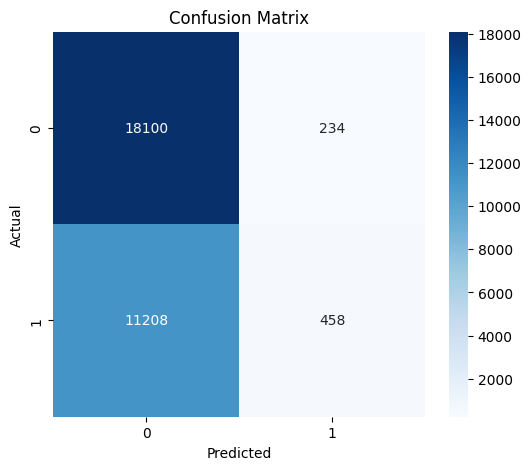

BATCH 46 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.5241, Val Loss: 0.4006
Epoch 2/20, Train Loss: 0.3929, Val Loss: 0.3677
Epoch 3/20, Train Loss: 0.3640, Val Loss: 0.3475
Epoch 4/20, Train Loss: 0.3547, Val Loss: 0.3303
Epoch 5/20, Train Loss: 0.3273, Val Loss: 0.3113
Epoch 6/20, Train Loss: 0.3157, Val Loss: 0.2991
Epoch 7/20, Train Loss: 0.3032, Val Loss: 0.2889
Epoch 8/20, Train Loss: 0.2922, Val Loss: 0.2891
Epoch 9/20, Train Loss: 0.2895, Val Loss: 0.2703
Epoch 10/20, Train Loss: 0.2749, Val Loss: 0.2488
Epoch 11/20, Train Loss: 0.2647, Val Loss: 0.2481
Epoch 12/20, Train Loss: 0.2435, Val Loss: 0.2300
Epoch 13/20, Train Loss: 0.2368, Val Loss: 0.2226
Epoch 14/20, Train Loss: 0.2285, Val Loss: 0.2197
Epoch 15/20, Train Loss: 0.2136, Val Loss: 0.2150
Epoch 16/20, Train Loss: 0.2114, Val Loss: 0.2103
Epoch 17/20, Train Loss: 0.2396, Val Loss: 0.2282
Epoch 18/20, Train Loss: 0.2367, Val Loss: 0.2061
Epoch 19/20, Train Loss: 0.2305, Val Loss: 0.2301
Epoch 20/20, Tr

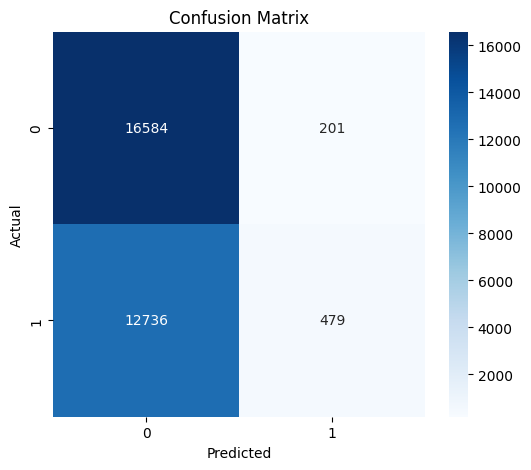

BATCH 47 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4570, Val Loss: 0.3798
Epoch 2/20, Train Loss: 0.3571, Val Loss: 0.3332
Epoch 3/20, Train Loss: 0.3331, Val Loss: 0.3167
Epoch 4/20, Train Loss: 0.3152, Val Loss: 0.3058
Epoch 5/20, Train Loss: 0.3021, Val Loss: 0.2820
Epoch 6/20, Train Loss: 0.2894, Val Loss: 0.2757
Epoch 7/20, Train Loss: 0.2923, Val Loss: 0.2646
Epoch 8/20, Train Loss: 0.2703, Val Loss: 0.2535
Epoch 9/20, Train Loss: 0.2649, Val Loss: 0.2396
Epoch 10/20, Train Loss: 0.2473, Val Loss: 0.2375
Epoch 11/20, Train Loss: 0.2468, Val Loss: 0.2304
Epoch 12/20, Train Loss: 0.2335, Val Loss: 0.2322
Epoch 13/20, Train Loss: 0.2391, Val Loss: 0.2255
Epoch 14/20, Train Loss: 0.2303, Val Loss: 0.2109
Epoch 15/20, Train Loss: 0.2313, Val Loss: 0.2221
Epoch 16/20, Train Loss: 0.2201, Val Loss: 0.2172
Epoch 17/20, Train Loss: 0.2243, Val Loss: 0.2116
Epoch 18/20, Train Loss: 0.2473, Val Loss: 0.2194
Epoch 19/20, Train Loss: 0.2286, Val Loss: 0.2119
Epoch 20/20, Tr

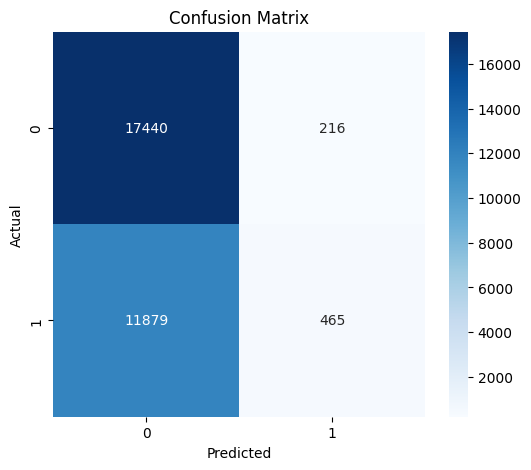

BATCH 48 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4104, Val Loss: 0.3471
Epoch 2/20, Train Loss: 0.3562, Val Loss: 0.3305
Epoch 3/20, Train Loss: 0.3354, Val Loss: 0.3103
Epoch 4/20, Train Loss: 0.3168, Val Loss: 0.2996
Epoch 5/20, Train Loss: 0.3041, Val Loss: 0.2872
Epoch 6/20, Train Loss: 0.2834, Val Loss: 0.2807
Epoch 7/20, Train Loss: 0.2758, Val Loss: 0.2675
Epoch 8/20, Train Loss: 0.2667, Val Loss: 0.2644
Epoch 9/20, Train Loss: 0.2642, Val Loss: 0.2799
Epoch 10/20, Train Loss: 0.2780, Val Loss: 0.2636
Epoch 11/20, Train Loss: 0.2744, Val Loss: 0.2776
Epoch 12/20, Train Loss: 0.2720, Val Loss: 0.2543
Epoch 13/20, Train Loss: 0.2500, Val Loss: 0.2221
Epoch 14/20, Train Loss: 0.2341, Val Loss: 0.2247
Epoch 15/20, Train Loss: 0.2202, Val Loss: 0.2230
Epoch 16/20, Train Loss: 0.2326, Val Loss: 0.1989
Epoch 17/20, Train Loss: 0.2067, Val Loss: 0.1959
Epoch 18/20, Train Loss: 0.2000, Val Loss: 0.2086
Epoch 19/20, Train Loss: 0.1990, Val Loss: 0.1956
Epoch 20/20, Tr

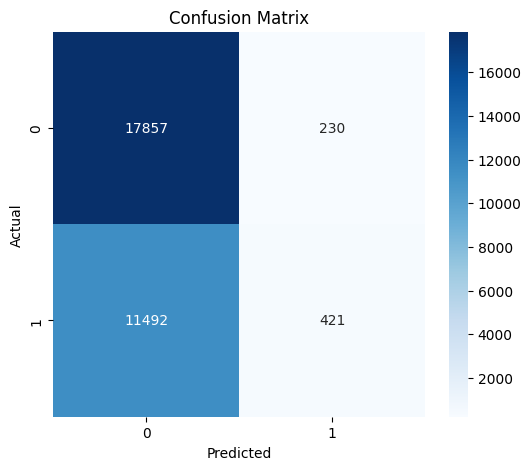

BATCH 49 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4452, Val Loss: 0.3591
Epoch 2/20, Train Loss: 0.3444, Val Loss: 0.3199
Epoch 3/20, Train Loss: 0.3218, Val Loss: 0.3014
Epoch 4/20, Train Loss: 0.2895, Val Loss: 0.2861
Epoch 5/20, Train Loss: 0.2824, Val Loss: 0.2677
Epoch 6/20, Train Loss: 0.2766, Val Loss: 0.2767
Epoch 7/20, Train Loss: 0.2699, Val Loss: 0.2407
Epoch 8/20, Train Loss: 0.2540, Val Loss: 0.2575
Epoch 9/20, Train Loss: 0.2711, Val Loss: 0.2645
Epoch 10/20, Train Loss: 0.2563, Val Loss: 0.2508
Epoch 11/20, Train Loss: 0.2547, Val Loss: 0.2505
Epoch 12/20, Train Loss: 0.2450, Val Loss: 0.2264
Epoch 13/20, Train Loss: 0.2317, Val Loss: 0.2209
Epoch 14/20, Train Loss: 0.2368, Val Loss: 0.2093
Epoch 15/20, Train Loss: 0.2246, Val Loss: 0.2491
Epoch 16/20, Train Loss: 0.2231, Val Loss: 0.2120
Epoch 17/20, Train Loss: 0.2167, Val Loss: 0.2210
Epoch 18/20, Train Loss: 0.2156, Val Loss: 0.2081
Epoch 19/20, Train Loss: 0.1997, Val Loss: 0.1898
Epoch 20/20, Tr

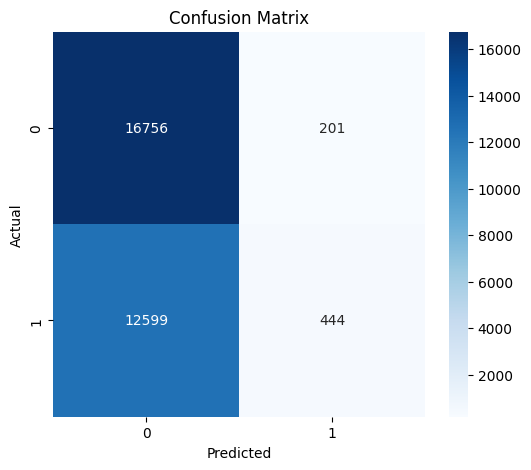

BATCH 50 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4142, Val Loss: 0.3330
Epoch 2/20, Train Loss: 0.3333, Val Loss: 0.3157
Epoch 3/20, Train Loss: 0.3087, Val Loss: 0.2911
Epoch 4/20, Train Loss: 0.2998, Val Loss: 0.2827
Epoch 5/20, Train Loss: 0.2866, Val Loss: 0.2682
Epoch 6/20, Train Loss: 0.2807, Val Loss: 0.2590
Epoch 7/20, Train Loss: 0.2756, Val Loss: 0.2575
Epoch 8/20, Train Loss: 0.2725, Val Loss: 0.2658
Epoch 9/20, Train Loss: 0.2671, Val Loss: 0.2727
Epoch 10/20, Train Loss: 0.2658, Val Loss: 0.2388
Epoch 11/20, Train Loss: 0.2463, Val Loss: 0.2350
Epoch 12/20, Train Loss: 0.2423, Val Loss: 0.2295
Epoch 13/20, Train Loss: 0.2238, Val Loss: 0.2061
Epoch 14/20, Train Loss: 0.2222, Val Loss: 0.2191
Epoch 15/20, Train Loss: 0.2218, Val Loss: 0.2092
Epoch 16/20, Train Loss: 0.2122, Val Loss: 0.2061
Epoch 17/20, Train Loss: 0.2151, Val Loss: 0.1940
Epoch 18/20, Train Loss: 0.2147, Val Loss: 0.1992
Epoch 19/20, Train Loss: 0.1987, Val Loss: 0.2098
Epoch 20/20, Tr

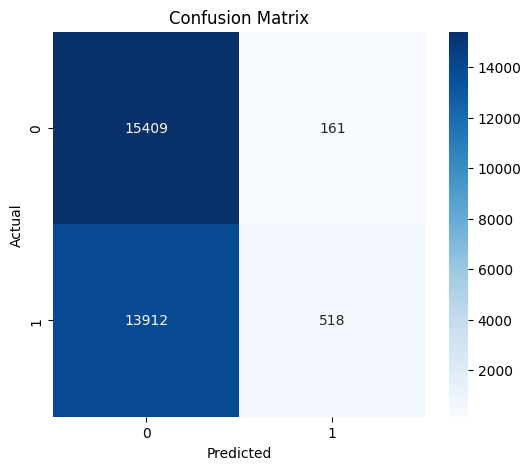

BATCH 51 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4777, Val Loss: 0.4124
Epoch 2/20, Train Loss: 0.4144, Val Loss: 0.3887
Epoch 3/20, Train Loss: 0.3646, Val Loss: 0.3466
Epoch 4/20, Train Loss: 0.3438, Val Loss: 0.3149
Epoch 5/20, Train Loss: 0.3210, Val Loss: 0.3068
Epoch 6/20, Train Loss: 0.3003, Val Loss: 0.2889
Epoch 7/20, Train Loss: 0.2876, Val Loss: 0.2797
Epoch 8/20, Train Loss: 0.2734, Val Loss: 0.2590
Epoch 9/20, Train Loss: 0.2588, Val Loss: 0.2522
Epoch 10/20, Train Loss: 0.2551, Val Loss: 0.2405
Epoch 11/20, Train Loss: 0.2426, Val Loss: 0.2347
Epoch 12/20, Train Loss: 0.2339, Val Loss: 0.2351
Epoch 13/20, Train Loss: 0.2490, Val Loss: 0.2335
Epoch 14/20, Train Loss: 0.2479, Val Loss: 0.2523
Epoch 15/20, Train Loss: 0.2478, Val Loss: 0.2464
Epoch 16/20, Train Loss: 0.2549, Val Loss: 0.2321
Epoch 17/20, Train Loss: 0.2319, Val Loss: 0.2209
Epoch 18/20, Train Loss: 0.2337, Val Loss: 0.2224
Epoch 19/20, Train Loss: 0.2434, Val Loss: 0.2433
Epoch 20/20, Tr

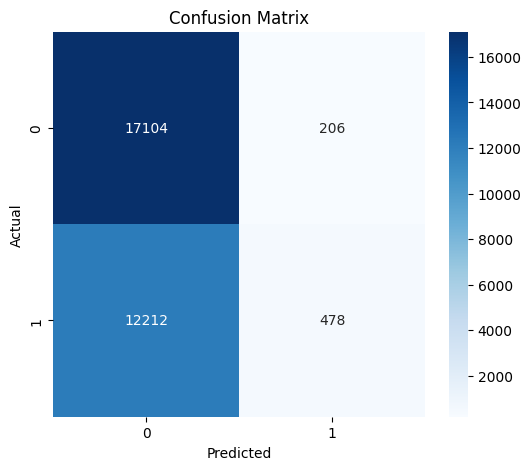

BATCH 52 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4286, Val Loss: 0.3400
Epoch 2/20, Train Loss: 0.3491, Val Loss: 0.3264
Epoch 3/20, Train Loss: 0.3207, Val Loss: 0.3011
Epoch 4/20, Train Loss: 0.3082, Val Loss: 0.2920
Epoch 5/20, Train Loss: 0.2950, Val Loss: 0.2815
Epoch 6/20, Train Loss: 0.2787, Val Loss: 0.2656
Epoch 7/20, Train Loss: 0.2713, Val Loss: 0.2554
Epoch 8/20, Train Loss: 0.2607, Val Loss: 0.2403
Epoch 9/20, Train Loss: 0.2438, Val Loss: 0.2341
Epoch 10/20, Train Loss: 0.2301, Val Loss: 0.2283
Epoch 11/20, Train Loss: 0.2326, Val Loss: 0.2263
Epoch 12/20, Train Loss: 0.2386, Val Loss: 0.2379
Epoch 13/20, Train Loss: 0.2392, Val Loss: 0.2284
Epoch 14/20, Train Loss: 0.2649, Val Loss: 0.2558
Epoch 15/20, Train Loss: 0.2442, Val Loss: 0.2237
Epoch 16/20, Train Loss: 0.2313, Val Loss: 0.2030
Epoch 17/20, Train Loss: 0.2056, Val Loss: 0.2086
Epoch 18/20, Train Loss: 0.2170, Val Loss: 0.2105
Epoch 19/20, Train Loss: 0.1977, Val Loss: 0.1838
Epoch 20/20, Tr

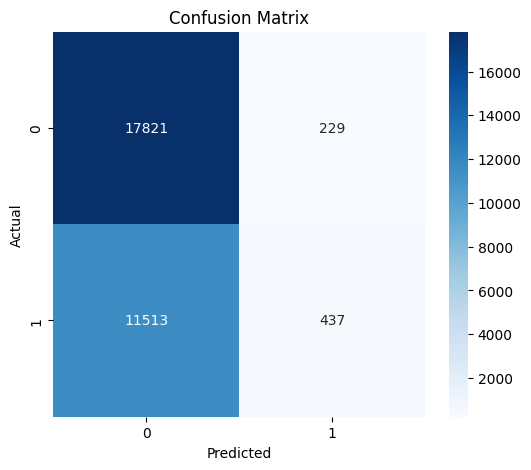

BATCH 53 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/20, Train Loss: 0.4823, Val Loss: 0.4026
Epoch 2/20, Train Loss: 0.3918, Val Loss: 0.3583
Epoch 3/20, Train Loss: 0.3697, Val Loss: 0.3539
Epoch 4/20, Train Loss: 0.3372, Val Loss: 0.3133
Epoch 5/20, Train Loss: 0.3239, Val Loss: 0.3022
Epoch 6/20, Train Loss: 0.3104, Val Loss: 0.2783
Epoch 7/20, Train Loss: 0.2889, Val Loss: 0.2683
Epoch 8/20, Train Loss: 0.2686, Val Loss: 0.2698
Epoch 9/20, Train Loss: 0.2658, Val Loss: 0.2485
Epoch 10/20, Train Loss: 0.2699, Val Loss: 0.2604
Epoch 11/20, Train Loss: 0.2778, Val Loss: 0.2726
Epoch 12/20, Train Loss: 0.2557, Val Loss: 0.2491
Epoch 13/20, Train Loss: 0.2517, Val Loss: 0.2376
Epoch 14/20, Train Loss: 0.2400, Val Loss: 0.2192
Epoch 15/20, Train Loss: 0.2300, Val Loss: 0.2202
Epoch 16/20, Train Loss: 0.2241, Val Loss: 0.2208
Epoch 17/20, Train Loss: 0.2261, Val Loss: 0.2088
Epoch 18/20, Train Loss: 0.2239, Val Loss: 0.2112
Epoch 19/20, Train Loss: 0.2199, Val Loss: 0.1980
Epoch 20/20, Tr

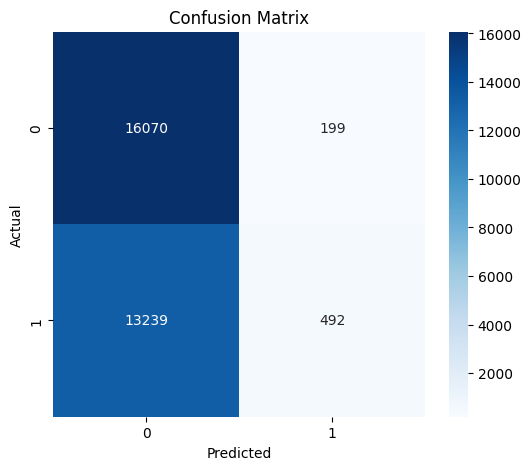

BATCH 54 out of TOTAL: 54 completed
Training Completed


In [6]:
import numpy as np
from vap_sound.config import MFCC_SAMPLE_RATE, FUTURE_OFFSET, HOP_LENGTH, N_MFCC_PER_FRAME, BATCH_SIZE, SEQ_LENGTH, LEARNING_RATE
from vap_sound.utils.extract_mfcc_torchaudio import MFCC_EXTRACTION

batch = 0
batch_file_size = 500
total = int(len(file_df)/batch_file_size)
model = VAPModel()
mfcc_extraction = MFCC_EXTRACTION()

for i in range(0, len(file_df)-batch_file_size, batch_file_size):
    # print(i)

    ## Training ##
    train_files = file_df['file_paths'][i: i+batch_file_size]
    # print(f"Training on {len(train_files)} files")
    # print(train_files)
    #  = extract_mfcc_features(train_files)
    training_data = mfcc_extraction.extract_mfcc_features(
        audio_files = train_files,
        target_sample_rate=MFCC_SAMPLE_RATE, 
        future_offset=FUTURE_OFFSET, 
        n_mfcc=N_MFCC_PER_FRAME, 
        hop_length=HOP_LENGTH  
    )
    train_model(training_data, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, seq_length=SEQ_LENGTH, learning_rate=LEARNING_RATE)

    # ## Evaluation
    random_integer = np.random.randint(1, len(file_df)- batch_file_size)
    eval_files = file_df['file_paths'][random_integer: random_integer + 300]
    eval_data = mfcc_extraction.extract_mfcc_features(
        audio_files=eval_files, 
        target_sample_rate=MFCC_SAMPLE_RATE, 
        future_offset=FUTURE_OFFSET, 
        n_mfcc=N_MFCC_PER_FRAME, 
        hop_length=HOP_LENGTH  
    )
    eval_dataset = VAPDataset(eval_data)
    eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=True)
    evaluate_model(model, eval_dataloader, output_file=LOG_MODEL_EVALUATION, metrics_file=LOG_MODEL_PREDICTION)

    batch += 1
    print(f"BATCH {batch} out of TOTAL: {total} completed")

print("Training Completed")